<a href="https://colab.research.google.com/github/uervitonsantos/Otimizacao-Politicaca-Manutencao-Preventiva-Imperfeita/blob/main/Algoritmo_PSO_para_otimiza%C3%A7%C3%A3o_de_custo_de_manuten%C3%A7%C3%A3o_preventiva_v9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Dataset de dados de confiabilidade: https://drive.google.com/drive/folders/1b7jqK1A2XI1oZ4YhDXw_4xdnSTbfuBVK?usp=sharing

In [108]:
%%capture
pip install pyswarms

In [109]:
import numpy as np
import pandas as pd
import math
import csv
import matplotlib.pyplot as plt
import time
from pyswarms.single.global_best import GlobalBestPSO
import pyswarms as ps
from pyswarms.utils.search import RandomSearch
from pyswarms.utils.functions import single_obj as fx
from pyswarms.utils.plotters import (plot_cost_history, plot_contour, plot_surface)
import plotly.graph_objects as go
from pyswarms.utils.plotters.formatters import Designer
from pyswarms.utils.plotters.formatters import Mesher
from mpl_toolkits.mplot3d import Axes3D

In [110]:
MAX_VALUE_CUSTO = 10000
fator_melhoria = 'expo'
DIAS_OBSERVADOS = 600

In [111]:
# Custos MC e MP
CMC = 4000
CMP = 2000

In [112]:
class IntensidadeFalha:
    # Este método vai inicializar cada objeto criado a partir desta classe
    # O nome deste método é "inicio"
    # (self) é uma referência a cada atributo de um objeto criado a partir desta classe
    # Os atributos de cada objeto criados a partir desta classe.
    # O self indica que estes são atributos dos objetos
    def __init__(self):
        self.fator = None
        self.lamb = None
        self.beta = None
        self.theta = None
        self.sz = None
        self.T = None
        self.u = None

    def inicio(self, T, fator, solucao):
        self.fator = fator
        self.lamb = solucao[0]
        self.beta = solucao[1]
        self.theta = solucao[2]
        self.sz = int(T[-1])
        self.T = T

    def create(self):
        self.u = []
        # Reducao de Idade com fator de melhoria linear
        for i, tc in enumerate(self.T[1:], start=1):
            for tt in range(int(self.T[i-1]), int(tc)+1):
                b = tt - self.fator[0][i-1] * self.T[i-1]
                self.u.append((1 / (self.lamb ** self.beta)) * self.beta * b ** (self.beta - 1))

                if tt == tc:
                    self.u.append(float('nan'))
            break
    # plota e salva a figura da função de intensidade de falha
    def plotar(self):
        fig = plt.figure(figsize=(20, 5))
        plt.plot(self.u)

        for xc in self.T:
            plt.axvline(x=xc, color='r', linestyle='--')

        plt.xlabel("Tempo (dias)")
        plt.ylabel("Função intensidade de falha")
        plt.xlim(0)
        plt.grid(True)
        plt.show()

In [113]:
# Define a função de melhoria constante
def const(ck, m, s, theta):
    fator = [[theta] * ck] * m
    return fator

In [114]:
# Define a função de melhoria linear
def linear(ck, m, s, theta):
    fator = []
    for k in range(0, m, 1):
        linha = [0]
        for j in range(0, ck, 1):
            linha.append(s[k][j] * theta)
        fator.append(linha)
    return fator

In [115]:
# Define a função de melhoria exponencial
def expo(ck, m, s, theta):
    fator = []
    for k in range(0, m):
        linha = []
        # Verifique se o índice k é válido
        if k >= len(s):
            break
        for j in range(0, ck):
            # Verifique se o índice j é válido
            if j >= len(s[k]):
                break
            linha.append(1.0 - math.exp(-s[k][j] * theta))
        fator.append(linha)

    return fator

In [116]:
# Define a função de melhoria potência
def pot(ck, m, s, theta):
    fator = []
    for k in range(0, m, 1):
        linha = []
        for j in range(0, ck, 1):
            linha.append(s[k][j] ** theta)
        fator.append(linha)
    return fator

In [117]:
# Define a função de melhoria para manutenção perfeita
def mpp(ck, m, s, theta):
    fator = []
    for k in range(0, m, 1):
        linha = []
        for j in range(0, ck, 1):
            linha.append(1)
        fator.append(linha)
    return fator

In [118]:
# Executa a função de melhoria com base no parâmetro fornecido
def execute_function(fator_melhoria, ck, m, s, theta):
    return {
        'const': lambda: const(ck, m, s, theta),
        'linear': lambda: linear(ck, m, s, theta),
        'expo': lambda: expo(ck, m, s, theta),
        'pot': lambda: pot(ck, m, s, theta),
        'mpp': lambda: mpp(ck, m, s, theta),
    }[fator_melhoria]()

In [119]:
# Função custo de manutenção baseada em severidade
def custo_mp(s, CMP):
    dist = {0.25: 2000, 0.5: 4000, 0.75: 12000, 1.0: 20000}
    if not isinstance(s, list):
        s = [s]  # Transforma s em uma lista com um único elemento
    cmp_f = np.sum([CMP if si < 0.25 or si > 1.0 else np.interp(si, [0.25, 0.5, 0.75, 1.0], [2000, 4000, 12000, 20000]) for si in s])
    return cmp_f

In [120]:
# Defina o dicionário de tipos de dados
dtypes = {
    't': int,
    'k': int,
    'c': int,
}

# Leitura dos dados de tempo de falha para 4 cenarios de exemplo
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/DateSet/Cenarios/cenario01.csv', sep=";")

# Remova as linhas com valores ausentes
df = df.fillna(0)

# Converta as colunas para os tipos de dados desejados
df = df.astype(dtypes)

df.head()

,t,k,c,n,s,T
0,90,1,1,4.0,0.4,0.0
1,110,1,1,0.0,0.5,150.0
2,125,1,1,9.0,0.9,250.0
3,135,1,1,2.0,0.2,500.0
4,295,1,3,2.0,0.4,600.0


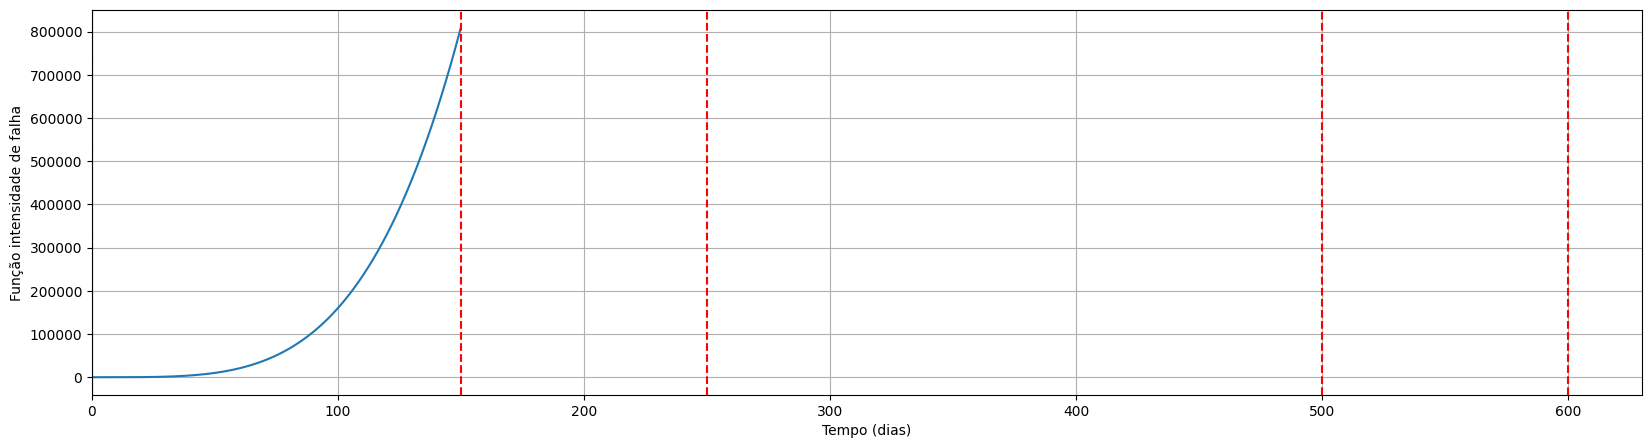

Fator ajuste:  [0.5506710358827784, 0.6321205588285577, 0.8347011117784134, 0.3296799539643607]


In [121]:
# Cria as variaveis
# tempos de falhas
t = df['t']
# indice do sistema
k = df['k']
m = k.drop_duplicates().shape[0]
# Numero de ciclos de manutenção
ck = df['c'].max()
# Numero de falhas e severidade das manutenções preventivas em cada sistema
n = []
s = []
for k in range(m):
    n.append(list(df['n'][k * ck:(k + 1) * ck]))
    s.append(list(df['s'][k * ck:(k + 1) * ck]))

# Tempos das MP
T = list(df['T'][:m])

# Criação de variáveis para os parâmetros
lamb = 5
theta = 2

# Cria alguns cenários de teste
beta = 5

solucao = [lamb, beta, theta]

# Cria a instância da classe IntensidadeFalha
intensidadeFalha = IntensidadeFalha()

# Inicializa a instância com os valores necessários
falha = intensidadeFalha.inicio(T, execute_function(fator_melhoria, ck, m, s, theta), solucao)

# Cria os dados da intensidade de falha
intensidadeFalha.create()

# Plota o gráfico da intensidade de falha
intensidadeFalha.plotar()

fator = execute_function(fator_melhoria, ck, m, s, theta)
print('Fator ajuste: ', fator[0])

last_value_fator_ajuste = fator[0][-1]

time_duration = 1
time.sleep(time_duration)

In [122]:
# Função objetivo para otimização da politica de manutenção
# Numero de ciclos determinado pela solução
# Solução com 24 valores reais
# Solucao a ser avaliada X = [x1, ..., x24]
def objective_st(x):

    # Dicionario para severidades
    dict_severidades = {1: 0.25, 3: 0.50, 5: 0.75, 7: 1.0}

    results = [] # Lista para armazenar os resultados das funções objetivo


    # No PSO, como cada particula é um vetor de dimenções definidas, é
    # Necessario interar sobre o vetor de particulas
    for particle in x:
        T = [0]
        s_row = []
        cont = 0

        for number in particle:
            modulo = int(number) % 2
            if modulo == 1:
                inteiro = int(number)
                s_row.append(dict_severidades[inteiro])  # Severidade
                frac = number - inteiro  # Tempo
                t = (cont + frac) * 30
                T.append(int(t))
            cont += 1

    s = []
    for row in range(m):
        s.append(s_row)

    # A partir da solução define o número de ciclos
    # A variável m é o número de sistemas em análise: em nosso exemplo m = 4
    # Para novos dados esse parâmetro deve ser ajustado
    # m = 4
    ck = len(T) - 1

    print("")
    print("=========================================================================")
    print("")
    print('Número de ciclos de manutenção:', ck, m)
    print('Tempos para manutenções preventivas:', T)
    print('Severidade para cada subsistema:', s[0])
    print("Número de Sisemas:", m)

    if ck == 0:
        return MAX_VALUE_CUSTO

    # O modelo já está ajustado
    # Utilizado para avaliar a solução candidata

    # Cria fator de meloria a partir da solução
    fact = execute_function(fator_melhoria, ck, m, s, theta)
    fator = [last_value_fator_ajuste] + list(fact[0])

    print('Fator: ', fator)

    # Numero esperado de falhas (NEF) em cada ciclo
    termos_somatorio = [((1/(lamb**beta)) * (T[1]**beta))]
    numero_medio_falhas = [0, ((1/(lamb**beta)) * (T[1]**beta))]

    for i in range(ck-1):
        termo = (((T[i+2]-fator[i]*T[i+1])**beta) - (((1-fator[i])*T[i+1])**beta)) * (1/(lamb**beta))
        termos_somatorio.append(termo)
        numero_medio_falhas.append(sum(termos_somatorio))

    # Número médio de falhas até o final do período: 2 anos
    final = DIAS_OBSERVADOS
    termo = (((final-fator[ck-1]*T[ck])**beta) - (((1-fator[ck-1])*T[ck])**beta)) * (1/(lamb**beta))
    termos_somatorio.append(termo)
    numero_medio_falhas.append(sum(termos_somatorio))

    mi = numero_medio_falhas

    print('Media de falhas: ', mi)

    Ctotal =  []

    for i in range(ck):
        cmp = custo_mp(s[0][i], CMP)
        Ctotal.append((cmp + (mi[i+1] - mi[i])*CMC)/(T[i+1]-T[i]))

    cmp = custo_mp(s[0][ck-1], CMP)
    Ctotal.append((cmp + (mi[ck+1] - mi[ck])*CMC)/(final-T[ck]))

    # Custo Total
    Custo = np.sum(Ctotal)
    results.append(Custo) # Adicione o valor da função objetivo à lista de resultados
    print('Custo = ', Custo)

    # Retorne os resultados da função objetivo como um array
    return np.array(results)

In [123]:
num_particles = 100
max_iterations = 100
dimensions = 24
options = {'c1': 0.5, 'c2': 0.3, 'w': 0.9}

max_bound = np.array([7.0] * dimensions)  # Limite superior dos valores em x
min_bound = np.array([0.0] * dimensions)   # Limite inferior dos valores em x
bounds = (min_bound, max_bound)

optimizer = GlobalBestPSO(n_particles=num_particles, dimensions=dimensions, options=options, bounds=bounds)

# Inicializar current_cost e pbest_cost com valores infinitos
optimizer.swarm.current_cost = np.full(optimizer.swarm.position.shape[0], np.inf)
optimizer.swarm.pbest_cost = np.full(optimizer.swarm.position.shape[0], np.inf)
best_cost, best_position = optimizer.optimize(objective_st, iters=max_iterations)

pbest_cost = optimizer.swarm.pbest_cost

best_positions = []  # Lista para armazenar todas as melhores posições

# Loop de iterações do PSO
for i in range(max_iterations):
    best_cost, best_position = optimizer.optimize(objective_st, iters=1)
    pbest_cost = optimizer.swarm.pbest_cost
    best_positions.append(best_position)

# Converter a lista de melhores posições em um array numpy para facilitar a manipulação
best_positions = np.array(best_positions)

2023-09-24 22:18:06,351 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   7%|▋         |7/100, best_cost=1.31e+11



Número de ciclos de manutenção: 9 5
Tempos para manutenções preventivas: [0, 43, 89, 123, 152, 271, 317, 358, 486, 567]
Severidade para cada subsistema: [0.25, 0.5, 0.25, 0.5, 0.25, 0.5, 0.25, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577]
Media de falhas:  [0, 47042.70176, 791170.9469758028, 2331435.1166119953, 2992850.867525118, 135306436.58460242, 153162568.88493404, 290106781.82022345, 655449273.3244138, 2340895356.9058123, 2477884313.538946]
Custo =  130955734760.54234


Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 52, 195, 217, 275, 324, 376, 397, 456, 495, 519, 605, 644, 661]
Severidade para cada subsistema: [0.25, 0.75, 0.5, 0.25, 0.5, 0.25, 0.5, 0.25, 0.5, 0.75, 0.25, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.776

pyswarms.single.global_best:  23%|██▎       |23/100, best_cost=8.48e+10



Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 24, 47, 61, 140, 283, 319, 340, 401, 461, 500, 531, 552]
Severidade para cada subsistema: [0.25, 0.5, 0.75, 0.25, 0.25, 0.5, 0.25, 0.5, 0.25, 0.25, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577]
Media de falhas:  [0, 2548.0396800000003, 31400.958411250067, 69783.48291883605, 3505203.603687529, 54884326.34244686, 130738422.74811703, 189219256.59036684, 250812652.0696141, 798677866.4782882, 880154099.2999873, 1394689584.4095247, 1806526259.100117, 2015265045.3649273]
Custo =  232346424634.66406


Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 45, 102, 172, 193, 286, 318, 350, 373, 424, 536, 556, 678]
Severidade para cada subsistem

pyswarms.single.global_best:  40%|████      |40/100, best_cost=8.48e+10



Número de ciclos de manutenção: 10 5
Tempos para manutenções preventivas: [0, 42, 88, 122, 288, 326, 330, 446, 539, 615, 653]
Severidade para cada subsistema: [0.5, 0.5, 0.75, 0.25, 0.5, 0.25, 0.5, 0.5, 0.25, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666]
Media de falhas:  [0, 41821.194240000004, 753635.9416986075, 1154468.691668097, 134552852.40142536, 137780756.12787914, 147967409.49913195, 380828259.67996, 1948464332.9875917, 2347168981.2184014, 2569753885.2130814, 971659328.5692694]
Custo =  254334136508.8471


Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 41, 135, 153, 189, 286, 324, 332, 386, 436, 454, 506, 538]
Severidade para cada subsistema: [0.75, 0.75, 0.75, 0.75, 0.25, 0.5, 0.25, 0.5, 0.25, 0.5, 0.25, 0.5]
Número de Sisemas: 5
Fator:  

pyswarms.single.global_best:  56%|█████▌    |56/100, best_cost=8.48e+10



Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 27, 59, 94, 136, 170, 288, 323, 331, 413, 430, 507, 552, 708]
Severidade para cada subsistema: [0.5, 0.75, 0.5, 0.5, 0.25, 0.25, 0.5, 0.25, 0.5, 0.75, 0.25, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577]
Media de falhas:  [0, 4591.65024, 104960.55010768014, 291027.5343187981, 606659.4456222715, 1847140.6728246673, 62918784.71157868, 140575206.6356154, 161034493.1621981, 264884433.50826472, 387538954.87018514, 586106469.5667149, 611813360.4829147, 8379310606.009244, 8022099156.815395]
Custo =  280308020849.1862


Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 38, 93, 164, 188, 288, 325, 332, 382, 416, 545, 713

pyswarms.single.global_best:  64%|██████▍   |64/100, best_cost=8.48e+10<ipython-input-122-3f464f4b430c>:86: RuntimeWarning: divide by zero encountered in double_scalars
  Ctotal.append((cmp + (mi[ck+1] - mi[ck])*CMC)/(final-T[ck]))
pyswarms.single.global_best:  76%|███████▌  |76/100, best_cost=8.48e+10



Número de ciclos de manutenção: 8 5
Tempos para manutenções preventivas: [0, 142, 153, 287, 323, 373, 441, 498, 713]
Severidade para cada subsistema: [0.5, 0.25, 0.25, 0.5, 0.75, 0.75, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577]
Media de falhas:  [0, 18475308.554240003, 20294860.10337453, 99946467.01498434, 179721695.5047568, 375130771.83557856, 476039625.3861611, 502088348.09001374, 1677067476.4883347, -2098459518.7729974]
Custo =  191327232943.71997


Número de ciclos de manutenção: 8 5
Tempos para manutenções preventivas: [0, 153, 287, 323, 351, 447, 494, 545, 661]
Severidade para cada subsistema: [0.5, 0.25, 0.5, 0.25, 0.5, 0.25, 0.5, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666

pyswarms.single.global_best:  97%|█████████▋|97/100, best_cost=7.17e+10



Número de ciclos de manutenção: 9 5
Tempos para manutenções preventivas: [0, 125, 224, 287, 322, 348, 380, 415, 502, 610]
Severidade para cada subsistema: [0.5, 0.75, 0.25, 0.5, 0.25, 0.75, 0.5, 0.25, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666]
Media de falhas:  [0, 9765625.0, 73743845.47054723, 93327088.76917864, 96031528.40355389, 174962169.57421422, 197535136.334593, 411416328.126055, 469033377.9552559, 1087493152.7708857, 803454887.1622841]
Custo =  183028583431.4829


Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 93, 217, 287, 322, 335, 388, 416, 449, 465, 497, 540, 609]
Severidade para cada subsistema: [0.5, 0.75, 0.25, 0.5, 0.25, 0.75, 0.5, 0.25, 0.25, 0.25, 0.5, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.7768698398515702,

pyswarms.single.global_best: 100%|██████████|100/100, best_cost=7.17e+10
2023-09-24 22:18:07,626 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 71738692518.4765, best pos: [4.7621551  5.63290878 5.29447194 2.2051584  5.18528706 4.89817693
 2.14807435 4.89266888 6.52554457 1.55687269 3.90929555 1.89526813
 3.01627075 4.63486735 4.93051042 3.20611682 1.42752017 3.94152732
 2.87331123 3.75859143 1.80987127 2.73554971 0.85039386 2.3391217 ]
2023-09-24 22:18:07,628 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702]
Media de falhas:  [0, 14539.335680000002, 14250688.306678446, 14274147.872870192, 15743138.60648471, 59465975.37063454, 62459889.65866577, 130981014.34905654, 231382982.0852063, 1189276520.358488, 1209207367.4686437, 1445224182.6170714, 1640187460.3852446, 1714055642.22546, 2396819710.5249662, -674455364.8959346]
Custo =  347761445323.03467


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=7.17e+10
2023-09-24 22:18:07,747 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 71738692518.4765, best pos: [4.72836538 5.63277817 5.29294105 2.20526549 5.18566538 4.90300358
 2.14390011 4.8910305  6.525516   1.55763129 3.90925443 3.86247102
 3.0138324  4.58980997 4.36451514 3.45116473 1.42864041 3.93945221
 2.87260138 3.75858186 1.82661256 2.73654981 0.84692631 2.33891185]
2023-09-24 22:18:07,805 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 36, 161, 216, 286, 324, 347, 422, 495, 538, 545, 594, 624]
Severidade para cada subsistema: [0.75, 0.5, 0.25, 0.25, 0.5, 0.25, 0.75, 0.25, 0.5, 0.5, 0.5, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666]
Media de falhas:  [0, 19349.176320000002, 23621362.0149881, 25590789.56790676, 48444305.78730966, 133504596.94879888, 202828285.5813403, 301358319.46172965, 1182464025.8402355, 1204429779.9454687, 1336982766.1391835, 1542663207.0488598, 1686579856.97791, 1600031856.90564]
Custo =  204942953486.32132


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=7.17e+10
2023-09-24 22:18:07,873 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 71738692518.4765, best pos: [4.72580009 5.6328559  5.2930687  2.20524406 5.18561645 4.90256176
 2.14355544 4.89173706 6.5255239  1.55735551 3.90926185 4.9034221
 3.01422144 4.61102689 1.41277798 3.40615166 1.42794581 3.93949877
 2.87272032 3.7585848  1.81489933 2.73650714 0.85009801 2.33899382]
2023-09-24 22:18:07,877 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 39, 120, 176, 286, 326, 351, 386, 420, 467, 491, 538, 592, 707]
Severidade para cada subsistema: [0.75, 0.75, 0.5, 0.25, 0.5, 0.25, 0.5, 0.75, 0.75, 0.25, 0.5, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577]
Media de falhas:  [0, 28871.743680000003, 4543091.936334912, 5782234.834563454, 29467495.096747458, 46004312.433586545, 124689231.77035141, 151311512.6059587, 369631824.5357455, 447775663.9658741, 454926514.1474102, 479972011.4565414, 1842045912.791111, 2991337009.823291, 2637377714.1058598]
Custo =  208221945880.5886


pyswarms.single.global_best:   0%|          |0/1, best_cost=7.17e+10



Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 43, 67, 137, 193, 237, 286, 328, 356, 374, 487, 537, 590]
Severidade para cada subsistema: [0.75, 0.75, 0.75, 0.5, 0.75, 0.25, 0.5, 0.25, 0.5, 0.25, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577]
Media de falhas:  [0, 47042.70176, 172288.50573416305, 1587712.1413272598, 3134984.771708414, 4688423.446580707, 18067375.877340224, 21973837.967645925, 114884108.00679696, 126028319.89074424, 1384388585.926432, 1527541969.387069, 2847256037.8263273, 2886192318.4852076]
Custo =  188743036766.49582


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=7.17e+10
2023-09-24 22:18:07,906 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 71738692518.4765, best pos: [4.72651171 5.63292861 5.29318441 2.20521748 5.18548984 4.90175597
 2.14373363 4.89241511 6.52553408 1.55706482 3.9092742  5.67175811
 3.01499585 4.63669157 6.27703481 3.33909941 1.42731775 3.93982171
 2.87299208 3.75858915 1.80333685 2.73635906 0.85299392 2.33910404]
2023-09-24 22:18:07,909 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=7.17e+10
2023-09-24 22:18:07,936 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 71738692518.4765, best pos: [4.73488757 5.63298995 5.29365844 2.20517942 5.18537475 4.9001573
 2.14483859 4.89308031 6.52554489 1.55677596 3.90929004 6.10152316
 3.01578699 4.6593287  4.2763408  3.27324688 1.4268131  3.94034356
 2.87332706 3.75859



Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 47, 74, 231, 286, 329, 362, 390, 485, 537, 589, 699]
Severidade para cada subsistema: [0.75, 0.75, 0.5, 0.25, 0.5, 0.5, 0.75, 0.25, 0.5, 0.5, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666]
Media de falhas:  [0, 73390.40224000001, 282797.3956850071, 50608466.82506636, 54885203.05699203, 73646418.78662473, 190026701.705356, 211425019.18795952, 438771809.272653, 467806065.5243285, 1754783080.5277433, 2792546471.243654, 2464401212.7318716]
Custo =  182338699207.5631


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=7.17e+10
2023-09-24 22:18:08,003 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 71738692518.4765, best pos: [4.74833989 5.63303809 5.29432512 2.20514364 5.18526125 4.89822958
 2.14649744 4.89364176 6.52555461 1.5565246  3.90930474 6.29133006
 3.01656148 4.67379189 2.49942946 3.19632093 1.42639717 3.94101789
 2.87362735 3.75859618 1.78940186 2.73574254 0.85636145 2.33928938]
2023-09-24 22:18:08,006 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 50, 80, 162, 207, 219, 286, 393, 460, 483, 536, 588]
Severidade para cada subsistema: [0.75, 0.75, 0.75, 0.25, 0.25, 0.25, 0.75, 0.25, 0.25, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577]
Media de falhas:  [0, 100000.00000000001, 417266.6669192187, 3592824.263037842, 4699014.941700019, 4845208.594693777, 93579025.1920843, 598663983.5257447, 1202097518.4658303, 1208470389.3485978, 2103775834.279825, 3381945881.8902755, 3428912988.4247494]
Custo =  243212395849.72867


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=7.17e+10
2023-09-24 22:18:08,022 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 71738692518.4765, best pos: [4.76057784 5.63305941 5.29493808 2.20511152 5.18516342 4.89648085
 2.14819111 4.89402423 6.52556235 1.55637869 3.90931768 6.77996074
 3.01717915 4.68646143 1.16169427 3.12808415 1.42624417 3.94164266
 2.87385527 3.75859784 1.78645985 2.73541519 0.85700235 2.33935973]
2023-09-24 22:18:08,023 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 10 5
Tempos para manutenções preventivas: [0, 53, 83, 175, 187, 233, 286, 393, 484, 536, 587]
Severidade para cada subsistema: [0.75, 0.75, 0.75, 0.25, 0.75, 0.25, 0.75, 0.25, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666, 0.7768698398515702, 0.3934693402873666, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577]
Media de falhas:  [0, 133822.55776000003, 502301.23814371135, 5778159.386750645, 5860036.573528729, 7482117.217034735, 78109652.20793942, 124306324.54173249, 1118415233.5447137, 1147263659.3698385, 2393249354.453621, 2444264227.8811536]
Custo =  166851775506.73706


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=7.17e+10
2023-09-24 22:18:08,035 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 71738692518.4765, best pos: [4.77164511 5.63305503 5.29543758 2.20508826 5.18510395 4.89524599
 2.14968059 4.89432967 6.52556656 1.5563784  3.90932622 0.16343434
 3.01768328 4.69424632 0.52068579 3.07899285 1.42622694 3.94218567
 2.87397862 3.75859886 1.78835345 2.73513641 0.85670818 2.33940641]
2023-09-24 22:18:08,036 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 7 5
Tempos para manutenções preventivas: [0, 54, 83, 286, 391, 486, 536, 587]
Severidade para cada subsistema: [0.75, 0.75, 0.25, 0.75, 0.25, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577]
Media de falhas:  [0, 146932.80768, 504009.50681402825, 171195153.83786842, 214730570.46625412, 1268414103.310432, 1295566923.0351732, 2541552618.1189556, 2592567491.5464883]
Custo =  165041101868.57172


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=7.17e+10
2023-09-24 22:18:08,049 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 71738692518.4765, best pos: [4.77881795 5.6330508  5.29579937 2.20508828 5.18506118 4.89477624
 2.15086543 4.89448162 6.52556835 1.55645826 3.90932531 1.42273171
 3.01813625 4.70028443 1.20610395 3.03642743 1.42645581 3.94262298
 2.87402797 3.75859971 1.79179124 2.7349178  0.85625195 2.33936925]
2023-09-24 22:18:08,050 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 8 5
Tempos para manutenções preventivas: [0, 55, 80, 286, 451, 489, 536, 587, 692]
Severidade para cada subsistema: [0.75, 0.75, 0.25, 0.25, 0.25, 0.5, 0.5, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666]
Media de falhas:  [0, 161051.0, 429300.8044179838, 180290744.92482153, 380664651.66517866, 829747260.2365584, 1627713074.2781262, 2873698769.361909, 3813124374.9990325, 3507321195.8372335]
Custo =  270396276649.44083


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=7.17e+10
2023-09-24 22:18:08,064 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 71738692518.4765, best pos: [4.78237313 5.63303361 5.29603332 2.20510926 5.18503081 4.89532038
 2.15166663 4.89457153 6.52556698 1.55656563 3.90931978 3.27001264
 3.0180179  4.69917899 2.42759712 3.0456062  1.42670451 3.9429478
 2.87390104 3.75859923 1.79698125 2.73484541 0.85525989 2.33927468]
2023-09-24 22:18:08,066 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 54, 75, 141, 174, 221, 286, 329, 470, 492, 537, 587, 713]
Severidade para cada subsistema: [0.75, 0.75, 0.75, 0.75, 0.5, 0.25, 0.5, 0.25, 0.25, 0.5, 0.5, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666]
Media de falhas:  [0, 146932.80768, 322944.24023563287, 1563005.1603379813, 1909303.0896254475, 3371156.4680691864, 9523890.163845358, 28285105.89347805, 1392736544.2624311, 1433287277.465561, 2204427208.321741, 3426961973.2696095, 4772697380.325121, 4399128004.460862]
Custo =  270784523930.54187


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=7.17e+10
2023-09-24 22:18:08,077 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 71738692518.4765, best pos: [4.7805434  5.63298846 5.29607356 2.20513058 5.18504865 4.89633947
 2.15179316 4.89428393 6.5255606  1.55671523 3.90930955 5.405162
 3.01746535 4.68997698 3.80621756 3.0801498  1.42716271 3.94311122
 2.87366987 3.75859832 1.80285447 2.73486895 0.85392757 2.33916962]
2023-09-24 22:18:08,079 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 53, 70, 128, 168, 184, 286, 327, 358, 495, 537, 588, 627]
Severidade para cada subsistema: [0.75, 0.75, 0.75, 0.75, 0.25, 0.25, 0.5, 0.25, 0.25, 0.5, 0.5, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666]
Media de falhas:  [0, 133822.55776000003, 243667.86719195324, 935365.2008345663, 1414041.9264338533, 1530426.1568619325, 20665636.156904753, 115600989.69339894, 220396670.12511668, 655941436.4358116, 1377623620.4710355, 2632208444.936855, 2827804284.0395627, 2730987311.409283]
Custo =  237946472818.15643


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=7.17e+10
2023-09-24 22:18:08,092 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 71738692518.4765, best pos: [4.77559175 5.63293882 5.29602413 2.2051576  5.18508749 4.89736953
 2.15147542 4.89355724 6.52555023 1.5568968  3.90929669 0.1316122
 3.01690046 4.67378948 5.24745584 3.13177484 1.4276359  3.94291619
 2.87339409 3.7585971  1.80943432 2.73499757 0.85182668 2.33906584]
2023-09-24 22:18:08,093 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 52, 66, 159, 205, 286, 325, 356, 452, 497, 538, 590, 623, 697]
Severidade para cada subsistema: [0.75, 0.75, 0.75, 0.25, 0.25, 0.5, 0.25, 0.5, 0.25, 0.5, 0.5, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577]
Media de falhas:  [0, 121665.29024000002, 194277.1930146465, 4836690.682552783, 5967767.52598346, 16368884.25860628, 104659187.36352047, 207109259.37935507, 387508441.1688169, 951524963.600654, 1065947225.2335205, 2361776723.479271, 2520434377.1169276, 3137893609.2013965, -9266488.176633835]
Custo =  373997527846.4524


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=7.17e+10
2023-09-24 22:18:08,108 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 71738692518.4765, best pos: [4.76752679 5.63288791 5.29553249 2.20518196 5.18513255 4.89841937
 2.15085236 4.89280444 6.52553969 1.55705904 3.90928492 2.39510383
 3.01621087 4.64840331 6.46591382 3.18099739 1.42804088 3.94235876
 2.87314469 3.75859465 1.8154536  2.73521289 0.84975366 2.33897856]
2023-09-24 22:18:08,109 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 15 5
Tempos para manutenções preventivas: [0, 49, 62, 151, 221, 286, 324, 354, 420, 475, 499, 538, 541, 592, 620, 715]
Severidade para cada subsistema: [0.75, 0.75, 0.75, 0.75, 0.25, 0.5, 0.25, 0.75, 0.5, 0.25, 0.5, 0.5, 0.5, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577]
Media de falhas:  [0, 90392.07968000001, 142968.86545628816, 3822698.9582292056, 7644905.119171235, 13797638.814947408, 16960146.28342302, 114002702.31369965, 195120409.23461777, 764170936.7307813, 771766632.3566995, 879842024.1847775, 935274813.8615403, 1147994561.5157535, 1278243751.7186267, 2207223984.7775545, -1649618322.5267296]
Custo =  355177517249.04083


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=7.17e+10
2023-09-24 22:18:08,121 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 71738692518.4765, best pos: [4.75926943 5.63284627 5.29482949 2.20519818 5.18520569 4.89930611
 2.14994683 4.8921199  6.52553156 1.55715423 3.90927624 5.03540135
 3.01560314 4.62464474 0.50683853 3.22960464 1.42835187 3.9417992
 2.87296824 3.75859222 1.81924371 2.73550463 0.84801235 2.33892529]
2023-09-24 22:18:08,123 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 47, 183, 286, 323, 353, 360, 420, 498, 538, 542, 594, 617]
Severidade para cada subsistema: [0.75, 0.5, 0.25, 0.5, 0.25, 0.5, 0.75, 0.25, 0.5, 0.5, 0.5, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666]
Media de falhas:  [0, 73390.40224000001, 42261218.3955935, 61923702.01427047, 76412536.28496411, 172352284.8915797, 175899904.5476036, 551777138.0860515, 741044643.781573, 760843399.7469839, 835208153.2260122, 1055647437.3919052, 1159180572.3540864, 1097016222.6639948]
Custo =  179094870324.61462


pyswarms.single.global_best:   0%|          |0/1, best_cost=7.17e+10



Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 45, 148, 194, 286, 322, 353, 365, 497, 539, 543, 596, 617]
Severidade para cada subsistema: [0.75, 0.5, 0.5, 0.25, 0.5, 0.25, 0.5, 0.25, 0.5, 0.5, 0.5, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666]
Media de falhas:  [0, 59049.00000000001, 13450622.446021952, 14424163.614438096, 51070242.85508129, 64913755.91571792, 163919648.05327436, 170486801.94762853, 1763847251.802203, 1882321992.8946135, 1957237780.2634704, 2185579986.9983892, 2279599613.844121, 2217435264.1540294]
Custo =  202956975072.44464


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=7.17e+10
2023-09-24 22:18:08,135 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 71738692518.4765, best pos: [4.75238826 5.63282194 5.29410441 2.20520713 5.18529401 4.89978826
 2.14906244 4.89158155 6.52552425 1.55718064 3.90927088 0.5966274
 3.01520745 4.60586125 2.73374739 3.27234674 1.42841875 3.94125347
 2.87289953 3.75859001 1.82259659 2.73577787 0.84710516 2.33892402]
2023-09-24 22:18:08,136 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=7.17e+10
2023-09-24 22:18:08,147 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 71738692518.4765, best pos: [4.74858066 5.63281882 5.29353754 2.20520056 5.18537227 4.90009101
 2.14826501 4.89138646 6.52552228 1.55715909 3.9092667  3.706772
 3.01507069 4.59492317 5.31108896 3.30117361 1.42827294 3.94082633
 2.87287926 3.7585882



Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 43, 146, 202, 286, 324, 354, 369, 496, 539, 543, 597, 617, 712]
Severidade para cada subsistema: [0.75, 0.5, 0.5, 0.25, 0.5, 0.25, 0.5, 0.25, 0.5, 0.5, 0.5, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577]
Media de falhas:  [0, 47042.70176, 12779181.845133835, 14512277.97034907, 45608153.05291161, 60760716.82038632, 157803272.85066295, 166490589.81146958, 1687025417.3995275, 1808754403.1360984, 1883670190.5049553, 2118594728.5830355, 2207897268.49024, 3122501007.3845205, -612605968.9600449]
Custo =  360252919903.01495


pyswarms.single.global_best:   0%|          |0/1, best_cost=7.17e+10



Número de ciclos de manutenção: 14 5
Tempos para manutenções preventivas: [0, 43, 149, 201, 231, 286, 325, 355, 371, 494, 538, 541, 597, 618, 698]
Severidade para cada subsistema: [0.75, 0.5, 0.5, 0.5, 0.25, 0.5, 0.25, 0.5, 0.25, 0.5, 0.5, 0.5, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577]
Media de falhas:  [0, 47042.70176, 14296167.27585803, 15723725.10564754, 18899112.077589776, 34679083.2164367, 50514175.82147425, 148669035.30831698, 158178215.62442228, 1607318790.6431472, 1731437440.9304643, 1786870230.607227, 2032126965.9296336, 2126748949.5336344, 2810015198.77777, -375302419.3846288]
Custo =  351349906894.0666


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=7.17e+10
2023-09-24 22:18:08,170 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 71738692518.4765, best pos: [4.74806585 5.63282661 5.29328809 2.20519116 5.18543321 4.90022373
 2.1475289  4.89153574 6.52552507 1.55706079 3.90926998 0.01078353
 3.01495855 4.59654401 0.53243419 3.30610243 1.42796035 3.94051506
 2.87286435 3.75858727 1.82459696 2.73619566 0.84676536 2.33901115]
2023-09-24 22:18:08,171 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=7.17e+10
2023-09-24 22:18:08,183 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 71738692518.4765, best pos: [4.74829955 5.63284844 5.29316406 2.20518056 5.18546685 4.89991125
 2.14700235 4.89194889 6.52553205 1.55692315 3.90927993 3.93235887
 3.01486225 4.60042578 3.72899344 3.2864921  1.42757064 3.94027006
 2.87286791 3.7585



Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 44, 61, 187, 286, 327, 356, 372, 492, 538, 597, 619]
Severidade para cada subsistema: [0.75, 0.75, 0.5, 0.25, 0.5, 0.25, 0.5, 0.25, 0.5, 0.5, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666]
Media de falhas:  [0, 52773.19168, 115155.69550677622, 17087561.450036883, 34707936.226252615, 51966076.28038803, 148062931.89833802, 157673139.41762945, 1548899887.0880463, 1679603415.147562, 3213498215.143134, 3313528808.7331333, 3244333877.044768]
Custo =  213098581426.27365


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=7.17e+10
2023-09-24 22:18:08,200 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 71738692518.4765, best pos: [4.75007847 5.63288384 5.29306289 2.20516963 5.18544963 4.89937356
 2.14668029 4.89237137 6.52554139 1.55678854 3.90929142 0.87609299
 3.01512639 4.61066237 6.83657641 3.264127   1.42720638 3.94025988
 2.87296898 3.7585865  1.82264552 2.73624037 0.84883917 2.33913727]
2023-09-24 22:18:08,201 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 46, 63, 286, 328, 357, 373, 466, 491, 538, 597, 620]
Severidade para cada subsistema: [0.75, 0.75, 0.25, 0.5, 0.25, 0.5, 0.5, 0.25, 0.5, 0.5, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666]
Media de falhas:  [0, 65908.15232000001, 137131.57563491608, 239697742.9987928, 243604205.0890985, 340796086.7798524, 350508125.2572197, 1221839932.1236475, 1268044244.2407022, 1402077234.7187915, 2935972034.714364, 3041501520.887648, 2968810965.053418]
Custo =  213685695880.72845


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=7.17e+10
2023-09-24 22:18:08,213 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 71738692518.4765, best pos: [4.7528993  5.63291986 5.29329125 2.20515688 5.18539002 4.89880109
 2.14652411 4.89283607 6.52554995 1.55668237 3.9093021  5.37080915
 3.01552141 4.62144867 2.46599584 3.23421758 1.42693763 3.9403051
 2.87314928 3.75858668 1.81784549 2.73613237 0.84977486 2.33919261]
2023-09-24 22:18:08,214 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 15 5
Tempos para manutenções preventivas: [0, 48, 66, 127, 208, 223, 286, 329, 358, 371, 452, 489, 538, 596, 622, 709]
Severidade para cada subsistema: [0.75, 0.75, 0.75, 0.25, 0.75, 0.25, 0.5, 0.25, 0.5, 0.5, 0.25, 0.5, 0.5, 0.25, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666]
Media de falhas:  [0, 81537.26976000001, 172268.366339118, 968925.0162193394, 5963380.156311572, 6173975.030869884, 89701702.27411082, 93812583.2693936, 192108837.18633395, 199730042.44966665, 873962272.5163313, 944364209.2070936, 1085131580.75948, 2583941288.3864098, 2705749283.1904206, 3510448843.901444, -104337594.87697887]
Custo =  366124769205.2512


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=7.17e+10
2023-09-24 22:18:08,227 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 71738692518.4765, best pos: [4.757799   5.63295197 5.2938252  2.20514579 5.18533031 4.89813483
 2.14643395 4.89323719 6.5255564  1.55662746 3.90931059 2.52834002
 3.01592898 4.63160745 5.14470062 3.19983898 1.42672376 3.94046627
 2.87334008 3.75858753 1.81324393 2.73597493 0.8506596  2.33922524]
2023-09-24 22:18:08,229 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 50, 69, 139, 191, 214, 286, 358, 369, 488, 538, 595, 624, 697]
Severidade para cada subsistema: [0.75, 0.75, 0.75, 0.25, 0.25, 0.25, 0.25, 0.5, 0.25, 0.5, 0.5, 0.25, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666]
Media de falhas:  [0, 100000.00000000001, 214289.25551569957, 1667251.7597815788, 2919707.536867221, 3263996.7479525493, 98560065.58332334, 333479741.60021794, 376774910.54860616, 1712088402.0963597, 1856261259.7814837, 3320349152.412751, 3459080674.6856084, 4066399995.44562, 919239898.0675898]
Custo =  375714602197.45435


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=7.17e+10
2023-09-24 22:18:08,245 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 71738692518.4765, best pos: [4.76330797 5.63297069 5.29432478 2.20513638 5.18526387 4.89753569
 2.14661128 4.89345195 6.52555981 1.55664565 3.90931702 6.95725057
 3.01632405 4.64170846 0.53249554 3.16906373 1.42661879 3.94083502
 2.87350873 3.75858941 1.80874618 2.7357588  0.85140584 2.33922474]




Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 52, 71, 149, 152, 180, 286, 329, 358, 365, 488, 538, 593, 625]
Severidade para cada subsistema: [0.75, 0.75, 0.75, 0.75, 0.25, 0.25, 0.5, 0.25, 0.5, 0.25, 0.5, 0.5, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666]
Media de falhas:  [0, 121665.29024000002, 250192.45508496085, 2578724.8574312865, 2585747.429785285, 2862564.1386190606, 24176452.577235915, 126009405.13578519, 224305659.05272555, 228052949.21206778, 1607996086.903462, 1752168944.5885859, 3147891740.424555, 3303239105.7118545, 3213256720.2050962]
Custo =  217914029907.41852


2023-09-24 22:18:08,247 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1<ipython-input-122-3f464f4b430c>:83: RuntimeWarning: divide by zero encountered in double_scalars
  Ctotal.append((cmp + (mi[i+1] - mi[i])*CMC)/(T[i+1]-T[i]))
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=7.17e+10
2023-09-24 22:18:08,259 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 71738692518.4765, best pos: [4.76330797 5.63297069 5.29432478 2.20513638 5.18526387 4.89753569
 2.14661128 4.89345195 6.52555981 1.55664565 3.90931702 6.95725057
 3.01632405 4.64170846 0.53249554 3.16906373 1.42661879 3.94083502
 2.87350873 3.75858941 1.80874618 2.7357588  0.85140584 2.33922474]




Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 0, 53, 73, 154, 286, 329, 358, 360, 488, 537, 592, 626]
Severidade para cada subsistema: [0.75, 0.75, 0.75, 0.75, 0.25, 0.5, 0.25, 0.5, 0.25, 0.5, 0.5, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666]
Media de falhas:  [0, 0.0, 133822.55776000003, 144197.0280959312, 2932888.1704011587, 43695117.1216153, 47805998.11689807, 146102252.03383842, 147094668.5603254, 1583163229.2159836, 1722934016.7547073, 3109167780.832945, 3276203744.383615, 3182798452.571062]
Custo =  inf


2023-09-24 22:18:08,261 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=7.17e+10
2023-09-24 22:18:08,272 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 71738692518.4765, best pos: [4.76330797 5.63297069 5.29432478 2.20513638 5.18526387 4.89753569
 2.14661128 4.89345195 6.52555981 1.55664565 3.90931702 6.95725057
 3.01632405 4.64170846 0.53249554 3.16906373 1.42661879 3.94083502
 2.87350873 3.75858941 1.80874618 2.7357588  0.85140584 2.33922474]
2023-09-24 22:18:08,274 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 0, 53, 73, 155, 215, 286, 328, 357, 489, 537, 591, 627]
Severidade para cada subsistema: [0.75, 0.75, 0.75, 0.75, 0.75, 0.25, 0.5, 0.25, 0.25, 0.5, 0.5, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666]
Media de falhas:  [0, 0.0, 133822.55776000003, 144197.0280959312, 3079204.8570331954, 5485879.150636021, 13032238.664518515, 16938700.754824214, 114130582.44557813, 506833659.84124076, 1327229390.2585592, 2680028121.414459, 2859015869.314594, 2762198896.6843143]
Custo =  inf


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=7.17e+10
2023-09-24 22:18:08,287 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 71738692518.4765, best pos: [4.77091789 5.63294516 5.29488493 2.20513969 5.18521109 4.89683033
 2.14729329 4.89311993 6.52555537 1.55681453 3.90931387 0.86179139
 3.0168395  4.64750058 6.16377464 3.15318105 1.42712844 3.94176813
 2.87359931 3.75859355 1.80281936 2.73542873 0.85191032 2.33917287]
2023-09-24 22:18:08,288 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 52, 71, 154, 185, 237, 286, 327, 357, 490, 537, 591, 626]
Severidade para cada subsistema: [0.75, 0.75, 0.75, 0.25, 0.25, 0.25, 0.5, 0.25, 0.25, 0.5, 0.5, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666]
Media de falhas:  [0, 121665.29024000002, 250192.45508496085, 3268871.672482728, 3635290.7640628424, 5856744.134370451, 71348876.8861591, 166284230.4226533, 266692402.8663141, 667147936.1767795, 1471146640.6275892, 2823945371.783489, 2996386249.2611966, 2902980957.4486437]
Custo =  243150180965.08218


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=7.17e+10
2023-09-24 22:18:08,303 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 71738692518.4765, best pos: [4.77106756 5.63292001 5.29468591 2.20515033 5.1852559  4.89699282
 2.14739518 4.89283705 6.52555153 1.55683187 3.90930408 1.3027133
 3.01681472 4.64250651 0.40876621 3.17225643 1.42734594 3.94182762
 2.87349528 3.75859407 1.80436481 2.73547674 0.85134257 2.33913502]




Número de ciclos de manutenção: 15 5
Tempos para manutenções preventivas: [0, 50, 69, 143, 152, 201, 229, 286, 326, 356, 453, 492, 537, 591, 625, 699]
Severidade para cada subsistema: [0.75, 0.75, 0.75, 0.75, 0.25, 0.75, 0.25, 0.5, 0.25, 0.5, 0.25, 0.5, 0.5, 0.25, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666]
Media de falhas:  [0, 100000.00000000001, 214289.25551569957, 2041018.352360012, 2067093.201891616, 3306844.236609559, 3905335.7998917745, 79678265.3986649, 83198425.8679995, 182475139.2915796, 367157666.7513505, 839111376.4985346, 965604036.6687925, 2318402767.8246927, 2484399703.9129853, 3108585686.62547, -115033979.17312336]
Custo =  370223889722.2293


2023-09-24 22:18:08,304 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=7.17e+10
2023-09-24 22:18:08,316 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 71738692518.4765, best pos: [4.77101768 5.63289564 5.29449379 2.20516092 5.18530055 4.89733143
 2.1476603  4.89257456 6.52554776 1.5568536  3.90929279 1.82893162
 3.0167513  4.63598418 2.32220333 3.19137953 1.42754438 3.94186218
 2.87335591 3.75859428 1.80707211 2.73552391 0.85060906 2.33909779]
2023-09-24 22:18:08,317 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 48, 67, 130, 238, 286, 326, 355, 361, 465, 493, 538, 592, 624]
Severidade para cada subsistema: [0.75, 0.75, 0.75, 0.25, 0.25, 0.5, 0.25, 0.5, 0.5, 0.25, 0.5, 0.5, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666]
Media de falhas:  [0, 81537.26976000001, 182821.75616587762, 1103504.691810529, 16544586.363412779, 19790180.256149612, 111371880.54406759, 206383003.28234977, 209444250.95209357, 1172685621.703949, 1225836521.0603456, 1353235362.5793362, 2715309263.9139056, 2869687158.795978, 2783139158.723708]
Custo =  215814257148.7249


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=7.17e+10
2023-09-24 22:18:08,330 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 71738692518.4765, best pos: [4.76896344 5.6328761  5.29431976 2.20516998 5.18533828 4.89777085
 2.14790282 4.89234504 6.52554404 1.55687337 3.90928327 2.30846419
 3.01669344 4.62988827 4.3204781  3.20894621 1.42771815 3.94186183
 2.87322381 3.75859406 1.80977081 2.73556668 0.84993186 2.33906839]
2023-09-24 22:18:08,331 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 46, 65, 222, 286, 325, 355, 362, 476, 494, 538, 592, 623]
Severidade para cada subsistema: [0.75, 0.75, 0.75, 0.25, 0.5, 0.25, 0.5, 0.5, 0.25, 0.5, 0.5, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666]
Media de falhas:  [0, 65908.15232000001, 155346.5656867069, 47635546.15442725, 53576772.66870481, 56914628.53155345, 155069488.0183962, 158695992.61933655, 1316844180.9073079, 1350093207.337059, 1474211857.624376, 2836285758.9589453, 2984484834.7414684, 2901382953.9676857]
Custo =  210885812912.53604


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=7.17e+10
2023-09-24 22:18:08,345 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 71738692518.4765, best pos: [4.76660514 5.63286176 5.29418967 2.20517481 5.18537069 4.89825906
 2.14813207 4.89221467 6.52554069 1.55689101 3.90927809 2.66135178
 3.01651766 4.6245252  6.17361328 3.22393994 1.42782863 3.94178313
 2.87312588 3.75859358 1.81221856 2.73560403 0.8494522  2.33905134]




Número de ciclos de manutenção: 14 5
Tempos para manutenções preventivas: [0, 45, 64, 183, 225, 286, 325, 355, 362, 494, 538, 541, 592, 622, 698]
Severidade para cada subsistema: [0.75, 0.75, 0.5, 0.25, 0.25, 0.5, 0.25, 0.5, 0.25, 0.5, 0.5, 0.5, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577]
Media de falhas:  [0, 59049.00000000001, 142976.26853080478, 13600778.646450857, 14812303.841729349, 33226755.94837626, 121517059.05329046, 219671918.54013318, 223298423.14107352, 1778600699.7842667, 1902719350.0715837, 1958152139.7483466, 2170871887.4025598, 2312990693.5153694, 2954373714.252568, -230943903.90983105]
Custo =  357740504146.7165


2023-09-24 22:18:08,347 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=7.17e+10



Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 45, 64, 187, 286, 325, 354, 362, 494, 538, 542, 593, 621, 709]
Severidade para cada subsistema: [0.75, 0.75, 0.5, 0.25, 0.5, 0.25, 0.5, 0.25, 0.5, 0.5, 0.5, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577]
Media de falhas:  [0, 59049.00000000001, 142976.26853080478, 15745191.508337595, 33365566.284553323, 49200658.88959087, 143135289.1318041, 147297942.721765, 1702600219.3649583, 1826718869.6522753, 1901083623.1313035, 2115183314.1352715, 2246258371.6218586, 3062668752.758304, -552117686.0201187]
Custo =  355962239743.5255



2023-09-24 22:18:08,364 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 71738692518.4765, best pos: [4.76375726 5.63285842 5.29412189 2.20517796 5.18538706 4.8986755
 2.14833044 4.8921082  6.52553778 1.55690329 3.90927351 2.93464239
 3.0163551  4.62141514 0.51690889 3.23702017 1.42783812 3.94168379
 2.87305974 3.75859277 1.81441562 2.7356334  0.84905731 2.33904273]
2023-09-24 22:18:08,368 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=7.17e+10
2023-09-24 22:18:08,379 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 71738692518.4765, best pos: [4.76093061 5.63286897 5.29414731 2.20517598 5.18539176 4.89894585
 2.14850227 4.89217588 6.52553563 1.5569065  3.90926977 3.16530729
 3.01618746 4.62109566 2.43927228 3.23953449 1.42779587 3.94158071
 2.87306361 3.75859204 1.81569537 2.73563494 0.8490618  2.3390539 ]




Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 45, 65, 182, 286, 325, 355, 362, 479, 494, 538, 541, 593, 621]
Severidade para cada subsistema: [0.75, 0.75, 0.5, 0.25, 0.5, 0.25, 0.5, 0.5, 0.25, 0.5, 0.5, 0.5, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666]
Media de falhas:  [0, 59049.00000000001, 152712.45439886526, 12737004.741893075, 32938233.905013546, 48773326.510051094, 146928185.99689382, 150554690.59783417, 1369204948.684851, 1396635092.3340905, 1520753742.6214075, 1576186532.2981703, 1795208772.1357226, 1926283829.6223097, 1850110413.4769342]
Custo =  202268858863.80222


2023-09-24 22:18:08,381 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=7.17e+10



Número de ciclos de manutenção: 14 5
Tempos para manutenções preventivas: [0, 46, 66, 222, 286, 326, 355, 362, 477, 493, 538, 540, 593, 622, 715]
Severidade para cada subsistema: [0.75, 0.75, 0.5, 0.25, 0.5, 0.25, 0.5, 0.5, 0.25, 0.5, 0.5, 0.5, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577]
Media de falhas:  [0, 65908.15232000001, 165619.07122241508, 46580126.07567161, 52521352.58994916, 69058169.92678824, 164069292.6650704, 167695797.26601076, 1345770950.1899629, 1374893480.1490924, 1502292321.6680832, 1539021712.9806712, 1763000123.7390094, 1899997144.3595371, 2803902234.5922995, -1052940072.7119846]
Custo =  360287202614.8434


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=7.17e+10
2023-09-24 22:18:08,405 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 71738692518.4765, best pos: [4.75845653 5.63288897 5.29426722 2.2051721  5.18537423 4.89915772
 2.14855689 4.89235891 6.52553575 1.55690192 3.90927352 3.04145287
 3.01603838 4.62152315 4.5359319  3.23320512 1.42769401 3.94147317
 2.87307901 3.75859123 1.81571993 2.73561392 0.84920069 2.33908028]
2023-09-24 22:18:08,407 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=7.17e+10



Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 48, 67, 286, 326, 355, 361, 469, 492, 538, 593, 623, 711]
Severidade para cada subsistema: [0.75, 0.75, 0.25, 0.5, 0.25, 0.5, 0.5, 0.25, 0.5, 0.5, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577]
Media de falhas:  [0, 81537.26976000001, 182821.75616587762, 224448168.0228832, 227968328.4922178, 322979451.2305, 326040698.9002438, 1360652694.4582973, 1403196232.1522822, 1533899760.211798, 2929622556.0477667, 3072638162.3750916, 3897681990.154748, 202837834.76091766]
Custo =  367930873225.92957


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=7.17e+10
2023-09-24 22:18:08,418 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 71738692518.4765, best pos: [4.75629867 5.6329076  5.29440812 2.20516532 5.18534339 4.8993176
 2.14849665 4.89259186 6.5255366  1.55689064 3.90927715 2.78422976
 3.01592195 4.62295031 6.50588716 3.2261723  1.42758263 3.9413862
 2.87310099 3.75859053 1.81503551 2.73557979 0.84964139 2.33911354]
2023-09-24 22:18:08,420 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=7.17e+10



Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 49, 69, 236, 286, 327, 356, 360, 461, 492, 538, 593, 624, 699]
Severidade para cada subsistema: [0.75, 0.75, 0.25, 0.25, 0.5, 0.25, 0.5, 0.5, 0.25, 0.5, 0.5, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577]
Media de falhas:  [0, 90392.07968000001, 210044.4859086331, 64808843.090854645, 68327898.39580777, 163263251.93230194, 259360107.55025196, 261361475.13363335, 1165431875.4317694, 1224464119.2989872, 1355167647.3585029, 2750890443.194472, 2900022435.376139, 3534513599.6031036, 310893933.8045101]
Custo =  366002299209.828


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=7.17e+10
2023-09-24 22:18:08,431 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 71738692518.4765, best pos: [4.75562426 5.63292471 5.29454487 2.20515726 5.18531011 4.89926601
 2.14842601 4.89282171 6.52553813 1.55687869 3.90928278 2.53203309
 3.01581762 4.62444556 0.87915633 3.21675374 1.42747183 3.94131137
 2.87313542 3.75859    1.81363553 2.73554163 0.85014554 2.33914567]
2023-09-24 22:18:08,432 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=7.17e+10
2023-09-24 22:18:08,447 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 71738692518.4765, best pos: [4.75683826 5.63293804 5.29465118 2.2051503  5.18527451 4.89917248
 2.14826879 4.89302742 6.52554029 1.55686739 3.90929155 2.13877278
 3.01581744 4.62737044 3.12913935 3.20596117 1.42738207 3.94126322
 2.8731743  3.7585



Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 50, 70, 123, 286, 327, 357, 453, 491, 538, 593, 625]
Severidade para cada subsistema: [0.75, 0.75, 0.75, 0.25, 0.5, 0.25, 0.5, 0.25, 0.5, 0.5, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666]
Media de falhas:  [0, 100000.00000000001, 226931.52779764181, 713461.9225875146, 80875909.73266186, 84585535.96688426, 184993708.41054508, 366785756.6425526, 823331935.920877, 957364926.3989663, 2353087722.2349353, 2508435087.522235, 2418452702.0154767]
Custo =  218148893789.72485


pyswarms.single.global_best:   0%|          |0/1, best_cost=7.17e+10



Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 51, 71, 129, 208, 286, 328, 357, 491, 538, 592, 626]
Severidade para cada subsistema: [0.75, 0.75, 0.75, 0.25, 0.25, 0.5, 0.25, 0.25, 0.5, 0.5, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666]
Media de falhas:  [0, 110408.08032000001, 244951.22748563965, 947177.1998988518, 5595828.524424329, 15064655.405532407, 113416797.27933097, 210608678.97008488, 618934873.5204813, 1429000672.5833447, 2791074573.9179144, 2958110537.4685845, 2864705245.6560316]
Custo =  239623911480.2939


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=7.17e+10
2023-09-24 22:18:08,460 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 71738692518.4765, best pos: [4.75948171 5.63294248 5.29470019 2.20514567 5.18524317 4.89902965
 2.1481134  4.89320633 6.52554269 1.55685843 3.90929998 1.77290917
 3.01587562 4.6308874  5.43907847 3.1962823  1.4273417  3.9412405
 2.87323811 3.75858953 1.8095692  2.73548894 0.85109851 2.33918764]
2023-09-24 22:18:08,461 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=7.17e+10



Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 51, 72, 133, 200, 220, 286, 328, 358, 491, 538, 592, 626, 705]
Severidade para cada subsistema: [0.75, 0.75, 0.75, 0.25, 0.25, 0.25, 0.5, 0.25, 0.25, 0.5, 0.5, 0.25, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666]
Media de falhas:  [0, 110408.08032000001, 259263.462520238, 1128774.998844454, 3823813.921400007, 4127912.3796052174, 91556930.82341112, 189909072.6972097, 291458364.00337327, 694619439.0136578, 1504685238.0765212, 2866759139.411091, 3033795102.961761, 3732245625.894163, 275728490.68681765]
Custo =  397175248491.6035


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=7.17e+10
2023-09-24 22:18:08,474 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 71738692518.4765, best pos: [4.76214113 5.63293796 5.29469938 2.20514264 5.18522717 4.8987419
 2.14797302 4.89326933 6.52554507 1.55685104 3.90930654 1.44466548
 3.01596632 4.63473006 0.4842433  3.18760972 1.42733219 3.9412314
 2.87329912 3.75858993 1.80774896 2.73548173 0.85134321 2.33918658]
2023-09-24 22:18:08,476 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=7.17e+10



Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 51, 72, 135, 195, 239, 286, 328, 358, 491, 538, 592, 626, 697]
Severidade para cada subsistema: [0.75, 0.75, 0.75, 0.25, 0.5, 0.25, 0.5, 0.25, 0.25, 0.5, 0.5, 0.25, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666]
Media de falhas:  [0, 110408.08032000001, 259263.462520238, 1247659.7650899286, 3142193.7825740087, 4734574.658837404, 67660142.05926912, 85659610.48365092, 187208901.78981447, 590369976.800099, 1400435775.8629622, 2762509677.1975317, 2929545640.748202, 3516765694.83729, 369605597.4592595]
Custo =  385455527866.35095


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=7.17e+10
2023-09-24 22:18:08,487 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 71738692518.4765, best pos: [4.76453752 5.63292974 5.2946408  2.20514248 5.18523029 4.89843481
 2.14787555 4.89316774 6.52554722 1.55684883 3.90931237 1.15495956
 3.01610132 4.63822279 3.54386306 3.18066847 1.42732795 3.94130644
 2.87335602 3.75859037 1.80651642 2.73548709 0.85131092 2.33917944]
2023-09-24 22:18:08,488 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=7.17e+10



Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 50, 72, 135, 192, 286, 328, 358, 491, 538, 592, 626, 691]
Severidade para cada subsistema: [0.75, 0.75, 0.75, 0.25, 0.25, 0.5, 0.25, 0.25, 0.5, 0.5, 0.25, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666]
Media de falhas:  [0, 100000.00000000001, 255215.35352071794, 1243611.6560904086, 2841889.5071814973, 18150045.75310664, 116502187.6269052, 218051478.93306875, 621212553.9433533, 1431278353.0062165, 2793352254.340786, 2960388217.891456, 3471588144.6240873, 550387855.233499]
Custo =  385244758137.5882



2023-09-24 22:18:08,499 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 71738692518.4765, best pos: [4.76643759 5.63291859 5.2945533  2.20514326 5.18523544 4.8980958
 2.14784374 4.89306755 6.52554912 1.55685115 3.90931365 0.90383595
 3.01623806 4.64083132 6.3381323  3.18090092 1.42736203 3.94143298
 2.87339704 3.75859085 1.80639571 2.7354936  0.85126702 2.33917067]
2023-09-24 22:18:08,501 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=7.17e+10
2023-09-24 22:18:08,511 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 71738692518.4765, best pos: [4.76739337 5.63290644 5.29447326 2.20514439 5.18524593 4.89781351
 2.14784931 4.892952   6.52555007 1.55685864 3.90931121 0.82242663
 3.01636775 4.64245635 1.76873552 3.18404216 1.42742071 3.94156712
 2.87343133 3.75859137 1.80640754 2.73550158 0.85105913 2.33915284]
2023-09-24 22:18:08



Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 49, 72, 132, 194, 230, 286, 327, 357, 492, 538, 592, 626, 695]
Severidade para cada subsistema: [0.75, 0.75, 0.75, 0.25, 0.25, 0.25, 0.5, 0.25, 0.25, 0.5, 0.5, 0.25, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666]
Media de falhas:  [0, 90392.07968000001, 251978.13664782338, 1066499.308285201, 3106530.203134157, 4060585.309497279, 78545776.87374999, 173481130.41024417, 273889302.85390496, 690205710.5949025, 1483728554.9384642, 2845802456.2730336, 3012838419.823704, 3574036650.3925343, 502761574.97163343]
Custo =  392030534023.3211


pyswarms.single.global_best:   0%|          |0/1, best_cost=7.17e+10



Número de ciclos de manutenção: 14 5
Tempos para manutenções preventivas: [0, 48, 72, 129, 201, 286, 327, 357, 360, 450, 493, 538, 592, 625, 701]
Severidade para cada subsistema: [0.75, 0.75, 0.75, 0.25, 0.25, 0.5, 0.25, 0.5, 0.5, 0.25, 0.5, 0.5, 0.25, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666]
Media de falhas:  [0, 81537.26976000001, 249513.26278916828, 915529.3402309223, 4236594.647578247, 15991135.193506632, 110926488.73000081, 211334661.17366165, 212829434.68567, 946026769.2778358, 1032468150.9592899, 1159866992.4782805, 2521940893.81285, 2682597350.371373, 3334448255.7257266, 33787341.75130558]
Custo =  362808971321.636


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=7.17e+10
2023-09-24 22:18:08,529 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 71738692518.4765, best pos: [4.76726809 5.63289577 5.29440118 2.20514593 5.1852632  4.89765255
 2.14787249 4.89284088 6.52555041 1.55686885 3.90930803 0.89228095
 3.01648006 4.64311815 4.71270114 3.18912526 1.4274776  3.94168647
 2.87343078 3.75859186 1.806503   2.73551646 0.85086826 2.33913443]
2023-09-24 22:18:08,530 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=7.17e+10



Número de ciclos de manutenção: 15 5
Tempos para manutenções preventivas: [0, 47, 71, 126, 150, 208, 286, 327, 357, 360, 457, 493, 538, 592, 625, 715]
Severidade para cada subsistema: [0.75, 0.75, 0.75, 0.75, 0.25, 0.25, 0.5, 0.25, 0.5, 0.5, 0.25, 0.5, 0.5, 0.25, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666]
Media de falhas:  [0, 73390.40224000001, 232040.4643799789, 802688.7135092891, 920077.477943534, 2955590.8943494116, 12424417.775457488, 107359771.31195167, 207767943.7556125, 209262717.26762083, 1048413767.8920223, 1118827845.4493494, 1246226686.96834, 2608300588.3029094, 2768957044.8614326, 3635809489.1627316, -221032818.14155245]
Custo =  372160471922.80896


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=7.17e+10
2023-09-24 22:18:08,545 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 71738692518.4765, best pos: [4.76571962 5.63288791 5.2943451  2.20515068 5.18528452 4.89761671
 2.14793822 4.89273116 6.52554981 1.55687814 3.90930515 1.08624651
 3.01654961 4.64251932 0.38119398 3.19441951 1.4275403  3.94174741
 2.87340352 3.75859226 1.80679304 2.73553637 0.85057122 2.33911769]
2023-09-24 22:18:08,548 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=7.17e+10



Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 47, 70, 123, 226, 286, 326, 356, 361, 463, 493, 538, 592, 624]
Severidade para cada subsistema: [0.75, 0.75, 0.75, 0.25, 0.25, 0.5, 0.25, 0.5, 0.5, 0.25, 0.5, 0.5, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666]
Media de falhas:  [0, 73390.40224000001, 217391.6742820259, 703922.0690718987, 12785071.125622777, 17935261.18983431, 109516961.47775228, 208793674.9013324, 211333859.44862783, 1140191506.2667408, 1197558731.051769, 1324957572.5707598, 2687031473.905329, 2841409368.7874017, 2754861368.7151318]
Custo =  215323102313.4618


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=7.17e+10
2023-09-24 22:18:08,560 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 71738692518.4765, best pos: [4.76400001 5.63288509 5.29430466 2.20515541 5.18530425 4.89761132
 2.14800636 4.8926243  6.52554843 1.55688579 3.90930045 1.38371879
 3.0165635  4.64153932 3.49304793 3.2023405  1.42759506 3.94176725
 2.87337724 3.75859258 1.80754192 2.73555484 0.85025927 2.33910366]
2023-09-24 22:18:08,562 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=7.17e+10



Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 46, 69, 121, 232, 286, 326, 356, 361, 467, 493, 538, 592, 624]
Severidade para cada subsistema: [0.75, 0.75, 0.75, 0.5, 0.25, 0.5, 0.25, 0.5, 0.5, 0.25, 0.5, 0.5, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666]
Media de falhas:  [0, 65908.15232000001, 201686.39664013067, 646368.5633077717, 16656733.294465195, 20773081.095191207, 37309898.43203029, 136586611.85561043, 139126796.40290585, 1137614243.320036, 1186612165.23117, 1314011006.7501607, 2676084908.08473, 2830462802.9668026, 2743914802.8945327]
Custo =  209025664092.185



2023-09-24 22:18:08,579 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 71738692518.4765, best pos: [4.76233346 5.63288433 5.29427811 2.20516051 5.18531752 4.8977588
 2.14808514 4.89253723 6.52554664 1.55688928 3.90929553 1.76035406
 3.01648861 4.64050696 6.63203757 3.20947782 1.42763052 3.94178266
 2.87334123 3.75859258 1.80858826 2.73557013 0.85000683 2.33909106]
2023-09-24 22:18:08,582 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=7.17e+10
2023-09-24 22:18:08,596 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 71738692518.4765, best pos: [4.76083343 5.63288573 5.29431016 2.20516483 5.18532249 4.89798666
 2.14815343 4.8924983  6.52554442 1.55688974 3.9092911  2.11593241
 3.0163653  4.63801296 2.00840255 3.21557472 1.42764184 3.94172553
 2.87330243 3.75859254 1.80953312 2.73558193 0.84987991 2.33908707]




Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 46, 67, 286, 326, 355, 361, 467, 493, 538, 592, 623, 694]
Severidade para cada subsistema: [0.75, 0.75, 0.25, 0.5, 0.25, 0.5, 0.5, 0.25, 0.5, 0.5, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577]
Media de falhas:  [0, 65908.15232000001, 176732.47870370554, 224442078.74542102, 227962239.21475562, 322973361.9530378, 326034609.62278163, 1324522056.5399117, 1373519978.4510458, 1500918819.9700365, 2862992721.304606, 3011191797.087129, 3588886120.5894074, 555340322.0737967]
Custo =  357812137215.9204


2023-09-24 22:18:08,598 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=7.17e+10
2023-09-24 22:18:08,612 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 71738692518.4765, best pos: [4.75972101 5.63288962 5.29438337 2.20516854 5.18532656 4.89821974
 2.14819742 4.89250543 6.52554244 1.55688777 3.90928792 2.38486501
 3.01624713 4.63517148 4.5965186  3.21887008 1.42764844 3.94162468
 2.87326967 3.7585925  1.81040029 2.73559182 0.84982638 2.33909296]
2023-09-24 22:18:08,613 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 46, 67, 212, 286, 326, 355, 361, 466, 493, 538, 593, 623, 702]
Severidade para cada subsistema: [0.75, 0.75, 0.25, 0.25, 0.5, 0.25, 0.5, 0.5, 0.25, 0.5, 0.5, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577]
Media de falhas:  [0, 65908.15232000001, 176732.47870370554, 33678237.01289229, 42007070.07160935, 133588770.35952732, 228599893.0978095, 231661140.7675533, 1212416752.7228363, 1263483354.7931674, 1390882196.312158, 2786604992.148127, 2929620598.475452, 3616945963.8875613, 277544058.4355211]
Custo =  368291177758.9565


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=7.17e+10



Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 47, 66, 229, 286, 326, 355, 361, 464, 492, 538, 593, 623, 707]
Severidade para cada subsistema: [0.75, 0.75, 0.5, 0.25, 0.5, 0.25, 0.5, 0.5, 0.25, 0.5, 0.5, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577]
Media de falhas:  [0, 73390.40224000001, 168611.57581194793, 56911355.09283449, 61522855.52313895, 78059672.85997804, 173070795.59826022, 176132043.26800403, 1122074757.7739224, 1174806673.56405, 1305510201.6235657, 2701232997.4595346, 2844248603.7868595, 3606124223.237913, 70777695.6042943]
Custo =  363194297428.6637



2023-09-24 22:18:08,628 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 71738692518.4765, best pos: [4.759056   5.63289537 5.29447002 2.20516911 5.18532936 4.89841743
 2.14822398 4.8925557  6.52554087 1.55688464 3.9092872  2.49801325
 3.01614525 4.63259772 0.01648903 3.22053851 1.42761655 3.94151928
 2.8732482  3.75859217 1.81109419 2.73559613 0.84993571 2.33910507]
2023-09-24 22:18:08,630 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=7.17e+10
2023-09-24 22:18:08,644 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 71738692518.4765, best pos: [4.75874352 5.63290423 5.29454841 2.20516948 5.18533149 4.89856057
 2.14821133 4.89262986 6.52553965 1.55688166 3.90928863 2.58165986
 3.01605791 4.63044429 3.27443111 3.22173892 1.42757109 3.94142487
 2.87324714 3.75859172 1.81139362 2.73558985 0.85004326 2.33911801]
2023-09-24 22:18:0



Número de ciclos de manutenção: 14 5
Tempos para manutenções preventivas: [0, 48, 66, 120, 286, 326, 355, 360, 461, 492, 538, 540, 593, 623, 701]
Severidade para cada subsistema: [0.75, 0.75, 0.75, 0.25, 0.5, 0.25, 0.5, 0.5, 0.25, 0.5, 0.5, 0.5, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577]
Media de falhas:  [0, 81537.26976000001, 172268.366339118, 662699.1754626937, 85852589.96563421, 89372750.4349688, 184383873.17325097, 186896176.2801052, 1090966576.5782413, 1149998820.4454591, 1280702348.5049748, 1317431739.8175628, 1541410150.575901, 1684425756.9032261, 2357410448.852317, -943250465.1221042]
Custo =  347033096314.1295


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=7.17e+10
2023-09-24 22:18:08,656 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 71738692518.4765, best pos: [4.75874646 5.63291271 5.29461207 2.20516774 5.18532466 4.89864647
 2.14816452 4.89270514 6.52553946 1.55687844 3.90929116 2.50236411
 3.01601782 4.62956389 6.35785513 3.22015273 1.42752162 3.94135906
 2.87325612 3.7585913  1.8115386  2.7355837  0.85019238 2.33913029]




Número de ciclos de manutenção: 15 5
Tempos para manutenções preventivas: [0, 49, 66, 122, 218, 286, 327, 356, 360, 458, 492, 538, 540, 593, 623, 690]
Severidade para cada subsistema: [0.75, 0.75, 0.75, 0.25, 0.25, 0.5, 0.25, 0.5, 0.5, 0.25, 0.5, 0.5, 0.5, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577]
Media de falhas:  [0, 90392.07968000001, 176625.16076410067, 742725.7237097949, 9828470.576908274, 16650592.664982082, 111585946.20147626, 207682801.81942627, 209684169.40280765, 1064759191.4842026, 1130239513.2099793, 1260943041.269495, 1297672432.582083, 1521650843.3404212, 1664666449.6677463, 2191756768.057905, -692272854.619237]
Custo =  348414922501.60016


2023-09-24 22:18:08,658 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=7.17e+10
2023-09-24 22:18:08,669 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 71738692518.4765, best pos: [4.75898009 5.63291935 5.29463713 2.20516338 5.18531523 4.89865349
 2.14810984 4.89276982 6.52553989 1.55687446 3.9092942  2.32418617
 3.01601152 4.6297355  1.80805165 3.21566445 1.42747704 3.94134956
 2.87326638 3.75859096 1.81135999 2.73557628 0.85035014 2.33913955]
2023-09-24 22:18:08,671 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 14 5
Tempos para manutenções preventivas: [0, 50, 67, 124, 217, 286, 327, 356, 360, 454, 492, 538, 540, 592, 623]
Severidade para cada subsistema: [0.75, 0.75, 0.75, 0.5, 0.25, 0.5, 0.25, 0.5, 0.5, 0.25, 0.5, 0.5, 0.5, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666]
Media de falhas:  [0, 100000.00000000001, 191734.1028470007, 808509.8912407723, 8990100.321599562, 16047376.021217275, 33305516.07535269, 129402371.69330269, 131403739.27668408, 923979523.0470887, 998297595.3895441, 1129001123.44906, 1165730514.761648, 1383342582.4922523, 1531541658.2747757, 1448439777.5009928]
Custo =  194461955807.61816


pyswarms.single.global_best:   0%|          |0/1, best_cost=7.17e+10



Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 50, 68, 126, 217, 286, 327, 357, 451, 492, 538, 592, 624]
Severidade para cada subsistema: [0.75, 0.75, 0.75, 0.75, 0.25, 0.5, 0.25, 0.5, 0.25, 0.5, 0.5, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666]
Media de falhas:  [0, 100000.00000000001, 202574.09838492348, 873590.8200023016, 8541078.212045886, 15598353.9116636, 19307980.145886004, 119716152.58954683, 293110543.46518815, 788292001.1827636, 918995529.2422793, 2281069430.576849, 2435447325.4589214, 2348899325.3866515]
Custo =  216243555471.4029


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=7.17e+10
2023-09-24 22:18:08,689 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 71738692518.4765, best pos: [4.75986824 5.63292405 5.2946276  2.20515808 5.18530521 4.89863051
 2.14805933 4.89280905 6.52554086 1.55687042 3.90929732 2.15060246
 3.01608189 4.6312075  4.36837114 3.21101892 1.42744272 3.94137824
 2.87328163 3.75859066 1.81114864 2.73556837 0.85049354 2.33914567]
2023-09-24 22:18:08,691 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=7.17e+10



Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 51, 69, 128, 208, 286, 327, 357, 492, 538, 592, 624, 713]
Severidade para cada subsistema: [0.75, 0.75, 0.75, 0.25, 0.25, 0.5, 0.25, 0.25, 0.5, 0.5, 0.25, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666]
Media de falhas:  [0, 110408.08032000001, 219326.64606250665, 948334.9553150914, 5767420.886301209, 15236247.767409287, 110171601.30390346, 210579773.7475643, 626896181.4885619, 1420419025.8321233, 2782492927.1666927, 2936870822.048765, 3782630639.32535, 7103644.064017773]
Custo =  396646104458.83405


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=7.17e+10
2023-09-24 22:18:08,702 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 71738692518.4765, best pos: [4.76085292 5.632925   5.29460679 2.20515337 5.18529544 4.89850263
 2.14801614 4.8928095  6.52554249 1.55686738 3.90929983 1.93304562
 3.01618562 4.63345365 6.74426285 3.20682229 1.42743083 3.94140659
 2.87329614 3.75859049 1.8108597  2.73556021 0.85061384 2.3391497 ]
2023-09-24 22:18:08,703 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=7.17e+10



Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 50, 69, 129, 203, 286, 327, 357, 492, 538, 592, 624, 708]
Severidade para cada subsistema: [0.75, 0.75, 0.75, 0.25, 0.25, 0.5, 0.25, 0.25, 0.5, 0.5, 0.25, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666]
Media de falhas:  [0, 100000.00000000001, 214289.25551569957, 993646.7848871392, 4658229.140977058, 15719802.579052642, 110655156.11554682, 211063328.55920765, 627379736.3002052, 1420902580.6437669, 2782976481.9783363, 2937354376.860409, 3703277099.0851784, 128287385.41504431]
Custo =  393873359412.28284


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=7.17e+10
2023-09-24 22:18:08,717 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 71738692518.4765, best pos: [4.7620826  5.63292212 5.29458307 2.20515051 5.18528495 4.89836193
 2.14799388 4.89276927 6.52554443 1.5568656  3.90930139 1.73417493
 3.01630008 4.63556383 1.7298481  3.20297734 1.42744265 3.94146731
 2.87330926 3.75859061 1.8104307  2.73555152 0.85066983 2.33915308]
2023-09-24 22:18:08,720 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=7.17e+10



Número de ciclos de manutenção: 14 5
Tempos para manutenções preventivas: [0, 50, 70, 129, 200, 286, 327, 357, 360, 450, 492, 538, 592, 624, 705]
Severidade para cada subsistema: [0.75, 0.75, 0.75, 0.25, 0.25, 0.5, 0.25, 0.5, 0.5, 0.25, 0.5, 0.5, 0.25, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666]
Media de falhas:  [0, 100000.00000000001, 226931.52779764181, 966921.4316203592, 4126154.687054918, 16239745.087931544, 111175098.62442572, 211583271.06808656, 213078044.5800949, 946275379.1722608, 1029719252.647668, 1160422780.7071838, 2522496682.0417533, 2676874576.9238257, 3397277980.88415, -59239154.32319546]
Custo =  364810767052.8611


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=7.17e+10
2023-09-24 22:18:08,733 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 71738692518.4765, best pos: [4.76320782 5.63291674 5.29453111 2.20514866 5.18527608 4.89818024
 2.14798877 4.89272344 6.52554617 1.55686439 3.9093017  1.55978327
 3.01639671 4.63739996 4.40008487 3.2003588  1.42747455 3.94153946
 2.87332146 3.75859078 1.80997275 2.73554334 0.85069599 2.33914891]
2023-09-24 22:18:08,738 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=7.17e+10



Número de ciclos de manutenção: 14 5
Tempos para manutenções preventivas: [0, 49, 70, 129, 198, 286, 327, 357, 360, 452, 493, 538, 592, 624, 707]
Severidade para cada subsistema: [0.75, 0.75, 0.75, 0.25, 0.25, 0.5, 0.25, 0.5, 0.5, 0.25, 0.5, 0.5, 0.25, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666]
Media de falhas:  [0, 90392.07968000001, 223004.1390334394, 962994.0428561568, 3817450.6204700246, 16675038.949812595, 111610392.48630677, 212018564.92996758, 213513338.44197592, 976017267.9982116, 1057786619.9756778, 1185185461.4946685, 2547259362.829238, 2701637257.7113104, 3452192077.1121826, -83154450.52143621]
Custo =  366455082566.7582



2023-09-24 22:18:08,760 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 71738692518.4765, best pos: [4.76401933 5.63291064 5.29447931 2.20514858 5.18526854 4.89801668
 2.14800266 4.89267227 6.52554729 1.55686397 3.90930019 1.46359122
 3.01645569 4.63838919 6.87829002 3.19891071 1.4275095  3.9416036
 2.87333024 3.75859109 1.80953711 2.73553674 0.85071774 2.3391426 ]
2023-09-24 22:18:08,762 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=7.17e+10



Número de ciclos de manutenção: 15 5
Tempos para manutenções preventivas: [0, 49, 69, 128, 200, 228, 286, 327, 357, 360, 454, 493, 538, 592, 625, 712]
Severidade para cada subsistema: [0.75, 0.75, 0.75, 0.25, 0.25, 0.25, 0.5, 0.25, 0.5, 0.5, 0.25, 0.5, 0.5, 0.25, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666]
Media de falhas:  [0, 90392.07968000001, 210044.4859086331, 939052.7951612178, 4223688.792111783, 4813617.0161414, 81875424.36498721, 176810777.9014814, 277218950.34514225, 278713723.85715055, 1071289507.6275553, 1148462003.2958739, 1275860844.8148646, 2637934746.149434, 2798591202.7079573, 3616093638.0339084, -119013338.31065702]
Custo =  374621840614.023


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=7.17e+10
2023-09-24 22:18:08,784 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 71738692518.4765, best pos: [4.76458225 5.63290507 5.29443141 2.20514895 5.18526363 4.89787489
 2.14801858 4.89262526 6.52554787 1.55686484 3.90929812 1.5043564
 3.01645403 4.63914539 1.94686172 3.19826751 1.42754323 3.94165142
 2.87333698 3.75859139 1.80915051 2.73553081 0.85064082 2.33913423]
2023-09-24 22:18:08,785 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=7.17e+10
2023-09-24 22:18:08,803 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 71738692518.4765, best pos: [4.76443143 5.63290058 5.29439332 2.20514941 5.18526337 4.89780086
 2.14804221 4.89259338 6.52554782 1.55686788 3.9092962  1.62437661
 3.01644301 4.63970471 4.48561856 3.19861316 1.42757077 3.94168195
 2.87334109 3.75859



Número de ciclos de manutenção: 15 5
Tempos para manutenções preventivas: [0, 48, 69, 126, 204, 224, 286, 327, 357, 360, 456, 493, 538, 592, 624, 718]
Severidade para cada subsistema: [0.75, 0.75, 0.75, 0.25, 0.5, 0.25, 0.5, 0.25, 0.5, 0.5, 0.25, 0.5, 0.5, 0.25, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666]
Media de falhas:  [0, 81537.26976000001, 206553.56447534135, 842665.168797333, 5142524.617047262, 5466335.65598817, 87697588.35002415, 104955728.40415956, 205363900.8478204, 206858674.35982874, 1030286461.650471, 1102935405.24868, 1230334246.7676706, 2592408148.10224, 2746786042.9843125, 3677555854.3026094, -302461459.10752535]
Custo =  370932708031.75964


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=7.17e+10
2023-09-24 22:18:08,840 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 71738692518.4765, best pos: [4.76384696 5.63289852 5.29436797 2.20515015 5.18526503 4.89781834
 2.14806711 4.89257658 6.52554733 1.55687119 3.90929447 1.74450487
 3.01639641 4.63880414 6.83757599 3.20000985 1.42759086 3.94170824
 2.87334357 3.75859184 1.80858685 2.7355353  0.85042525 2.33911361]




Número de ciclos de manutenção: 14 5
Tempos para manutenções preventivas: [0, 48, 68, 125, 208, 225, 286, 327, 356, 360, 458, 493, 538, 592, 624]
Severidade para cada subsistema: [0.75, 0.75, 0.75, 0.25, 0.75, 0.25, 0.5, 0.25, 0.5, 0.5, 0.25, 0.5, 0.5, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666]
Media de falhas:  [0, 81537.26976000001, 194233.06374903792, 820617.421723152, 6181044.428974612, 6440215.054712985, 87376763.87976778, 91086390.11399017, 187183245.73194018, 189184613.31532156, 1044259635.3967166, 1112456480.338034, 1239855321.8570247, 2601929223.191594, 2756307118.0736666, 2669759118.0013967]
Custo =  209953499349.27103


2023-09-24 22:18:08,842 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=7.17e+10



Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 47, 68, 123, 286, 327, 356, 361, 459, 493, 538, 592, 624]
Severidade para cada subsistema: [0.75, 0.75, 0.75, 0.25, 0.5, 0.25, 0.5, 0.5, 0.25, 0.5, 0.5, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666]
Media de falhas:  [0, 73390.40224000001, 191147.54720404893, 735387.3342040075, 80897835.14427835, 84607461.37850074, 180704316.99645075, 183244501.54374617, 1045858267.1093554, 1111855284.348662, 1239254125.8676524, 2601328027.202222, 2755705922.0842943, 2669157922.0120244]
Custo =  206597925160.265



2023-09-24 22:18:08,859 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 71738692518.4765, best pos: [4.76307534 5.63289723 5.294376   2.20515307 5.18526904 4.89784654
 2.14809017 4.89257514 6.52554657 1.55687454 3.90929296 1.88485215
 3.01635017 4.63737909 1.85199653 3.20212938 1.42759037 3.94168158
 2.873342   3.75859197 1.80858706 2.73554007 0.85032174 2.3391057 ]
2023-09-24 22:18:08,862 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=7.17e+10
2023-09-24 22:18:08,883 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 71738692518.4765, best pos: [4.76220112 5.63289943 5.29440117 2.20515632 5.18527297 4.89790883
 2.14810928 4.89257605 6.52554554 1.55687721 3.90929195 2.01403638
 3.01630199 4.63542608 3.7057689  3.20477397 1.42758001 3.94161568
 2.87333791 3.758592   1.80867745 2.73554544 0.85023759 2.33910112]




Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 47, 68, 122, 286, 326, 356, 361, 459, 493, 538, 592, 624]
Severidade para cada subsistema: [0.75, 0.75, 0.75, 0.25, 0.5, 0.25, 0.5, 0.5, 0.25, 0.5, 0.5, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666]
Media de falhas:  [0, 73390.40224000001, 191147.54720404893, 697680.589604489, 82508830.90663093, 86028991.37596552, 185305704.79954565, 187845889.34684107, 1050459654.9124504, 1116456672.151757, 1243855513.6707478, 2605929415.005317, 2760307309.8873897, 2673759309.8151197]
Custo =  206596340041.44678


2023-09-24 22:18:08,885 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=7.17e+10



Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 47, 67, 121, 222, 286, 326, 356, 361, 459, 492, 538, 592, 624]
Severidade para cada subsistema: [0.75, 0.75, 0.75, 0.75, 0.25, 0.5, 0.25, 0.5, 0.5, 0.25, 0.5, 0.5, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666]
Media de falhas:  [0, 73390.40224000001, 179442.2599058066, 677872.4944944538, 11667861.057746824, 17609087.572024375, 21129248.041358963, 120405961.46493909, 122946146.01223451, 985559911.5778439, 1048874085.4013996, 1179577613.4609153, 2541651514.7954845, 2696029409.677557, 2609481409.605287]
Custo =  205356973311.0406


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=7.17e+10
2023-09-24 22:18:08,908 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 71738692518.4765, best pos: [4.76141048 5.63290326 5.29443562 2.20515968 5.18527799 4.89799606
 2.14812006 4.89259405 6.52554451 1.55687931 3.90929123 2.11747639
 3.01625012 4.63353609 5.69699532 3.20728172 1.42756972 3.94155218
 2.87333093 3.75859185 1.80886327 2.73555055 0.85018387 2.33910092]
2023-09-24 22:18:08,911 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=7.17e+10



Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 47, 67, 121, 286, 326, 356, 360, 458, 492, 538, 593, 623]
Severidade para cada subsistema: [0.75, 0.75, 0.75, 0.25, 0.5, 0.25, 0.5, 0.5, 0.25, 0.5, 0.5, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666]
Media de falhas:  [0, 73390.40224000001, 179442.2599058066, 677872.4944944538, 84164726.91572082, 87684887.38505541, 186961600.80863553, 188962968.39201692, 1044037990.4734119, 1109518312.1991887, 1240221840.2587044, 2635944636.094673, 2778960242.421998, 2695858361.6482153]
Custo =  206677055802.96692



2023-09-24 22:18:08,933 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 71738692518.4765, best pos: [4.7607102  5.63290775 5.29446925 2.2051624  5.18528405 4.89808381
 2.1481199  4.89262965 6.52554359 1.55687935 3.90929118 2.18165978
 3.01620776 4.63190628 0.29308902 3.20941466 1.42755382 3.94148874
 2.87332244 3.75859168 1.80925833 2.7355549  0.85015008 2.33910166]
2023-09-24 22:18:08,935 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=7.17e+10
2023-09-24 22:18:08,952 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 71738692518.4765, best pos: [4.7602822  5.63291179 5.29449958 2.20516457 5.18529003 4.89817162
 2.14811546 4.89266371 6.52554288 1.55687758 3.90929224 2.17266047
 3.01616971 4.63114678 2.88184919 3.21073182 1.42753812 3.94143715
 2.87331456 3.75859148 1.80971742 2.73555785 0.85016794 2.33910668]
2023-09-24 22:18:0



Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 48, 68, 122, 221, 286, 327, 356, 360, 458, 492, 538, 592, 623]
Severidade para cada subsistema: [0.75, 0.75, 0.75, 0.5, 0.25, 0.5, 0.25, 0.5, 0.5, 0.25, 0.5, 0.5, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666]
Media de falhas:  [0, 81537.26976000001, 194233.06374903792, 700766.106149478, 10948327.20305118, 17101060.89882735, 34359200.95296277, 130456056.57091278, 132457424.15429416, 987532446.2356892, 1053012767.9614658, 1183716296.0209816, 2545790197.355551, 2693989273.138074, 2610887392.364291]
Custo =  206238795561.86487


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=7.17e+10
2023-09-24 22:18:08,974 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 71738692518.4765, best pos: [4.76003196 5.63291482 5.29452233 2.20516473 5.18529512 4.8982509
 2.14810087 4.89269569 6.52554225 1.55687521 3.9092934  2.10734829
 3.01615518 4.63078797 5.30286931 3.21147843 1.42751881 3.9413994
 2.87330708 3.7585913  1.81013698 2.73555928 0.85020912 2.33911545]




Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 48, 68, 123, 239, 286, 327, 356, 360, 457, 492, 538, 592, 623]
Severidade para cada subsistema: [0.75, 0.75, 0.75, 0.75, 0.25, 0.5, 0.25, 0.5, 0.5, 0.25, 0.5, 0.5, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666]
Media de falhas:  [0, 81537.26976000001, 194233.06374903792, 738472.8507489965, 20168161.404076077, 23282987.901274323, 26992614.135496728, 123089469.75344673, 125090837.33682811, 964241887.9612296, 1031905446.3870475, 1162608974.4465632, 2524682875.7811327, 2672881951.563656, 2589780070.789873]
Custo =  204794014323.6854


2023-09-24 22:18:08,982 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=7.17e+10



Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 49, 68, 125, 217, 286, 327, 356, 360, 456, 492, 538, 592, 623]
Severidade para cada subsistema: [0.75, 0.75, 0.75, 0.25, 0.25, 0.5, 0.25, 0.5, 0.5, 0.25, 0.5, 0.5, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666]
Media de falhas:  [0, 90392.07968000001, 198029.51611154526, 824413.8740856594, 8745627.97408954, 15802903.673707254, 110738257.21020144, 206835112.82815146, 208836480.41153285, 1032264267.7021751, 1102128378.1648555, 1232831906.2243712, 2594905807.558941, 2743104883.341464, 2660003002.5676813]
Custo =  213252628554.16473



2023-09-24 22:18:09,004 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 71738692518.4765, best pos: [4.76039821 5.63291674 5.29453429 2.20516431 5.18529855 4.89831637
 2.1480805  4.89272158 6.52554199 1.5568727  3.90929478 2.02211502
 3.01617473 4.63100615 0.39397726 3.21104509 1.42750144 3.94139374
 2.87330126 3.75859116 1.81048725 2.73556023 0.85025993 2.33912396]
2023-09-24 22:18:09,006 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=7.17e+10
2023-09-24 22:18:09,024 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 71738692518.4765, best pos: [4.76105742 5.63291706 5.29452993 2.2051638  5.18529836 4.89835768
 2.14806155 4.89274374 6.52554207 1.55687045 3.90929604 1.91482983
 3.01620099 4.63193101 3.60711808 3.20953836 1.4274889  3.94141932
 2.87329758 3.75859105 1.81064914 2.7355603  0.85031716 2.33913141]
2023-09-24 22:18:0



Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 49, 69, 127, 286, 327, 356, 360, 455, 492, 538, 592, 624]
Severidade para cada subsistema: [0.75, 0.75, 0.75, 0.25, 0.5, 0.25, 0.5, 0.5, 0.25, 0.5, 0.5, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666]
Media de falhas:  [0, 90392.07968000001, 210044.4859086331, 891339.1030205669, 74722472.80014987, 78432099.03437227, 174528954.6523223, 176530322.23570368, 984433650.9924458, 1056515856.4949001, 1187219384.554416, 2549293285.8889856, 2703671180.771058, 2617123180.698788]
Custo =  205345149693.00818


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=7.17e+10
2023-09-24 22:18:09,044 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 71738692518.4765, best pos: [4.76195931 5.63291674 5.29451204 2.20516238 5.18529589 4.89837233
 2.14804653 4.89275669 6.52554251 1.55686846 3.90929713 1.81561503
 3.01624367 4.63348832 6.5773226  3.20734852 1.4274789  3.94145671
 2.8732982  3.75859097 1.81070507 2.73555936 0.85038286 2.33913746]




Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 50, 69, 128, 286, 327, 357, 360, 454, 492, 538, 592, 624]
Severidade para cada subsistema: [0.75, 0.75, 0.75, 0.25, 0.5, 0.25, 0.5, 0.5, 0.25, 0.5, 0.5, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666]
Media de falhas:  [0, 100000.00000000001, 214289.25551569957, 943297.5647682843, 73255869.86863269, 76965496.10285509, 177373668.5465159, 178868442.05852425, 971444225.828929, 1045762298.1713843, 1176465826.2309, 2538539727.5654697, 2692917622.447542, 2606369622.3752723]
Custo =  205186263331.2625


2023-09-24 22:18:09,052 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=7.17e+10
2023-09-24 22:18:09,069 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 71738692518.4765, best pos: [4.76277436 5.63291493 5.29449205 2.20515999 5.18529125 4.89835958
 2.14803915 4.89276683 6.52554297 1.55686704 3.90929781 1.74471702
 3.01628505 4.63489662 2.24812898 3.20513026 1.42746994 3.94150689
 2.87329891 3.758591   1.81058144 2.73555845 0.85044385 2.33914241]
2023-09-24 22:18:09,072 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 50, 69, 129, 228, 286, 327, 357, 360, 453, 492, 538, 592, 624]
Severidade para cada subsistema: [0.75, 0.75, 0.75, 0.5, 0.25, 0.5, 0.25, 0.5, 0.5, 0.25, 0.5, 0.5, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666]
Media de falhas:  [0, 100000.00000000001, 214289.25551569957, 993646.7848871392, 11889892.52301408, 16675977.215108454, 33934117.269243866, 134342289.7129047, 135837063.22491303, 913280336.3369278, 989852277.2522854, 1120555805.3118012, 2482629706.646371, 2637007601.5284433, 2550459601.4561734]
Custo =  205192600288.86176


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=7.17e+10
2023-09-24 22:18:09,094 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 71738692518.4765, best pos: [4.76339715 5.63291279 5.29446823 2.20515762 5.1852863  4.8982961
 2.14803251 4.89276389 6.52554355 1.55686678 3.90929832 1.71495796
 3.01632032 4.63616134 5.38601863 3.20338332 1.42746637 3.94155363
 2.87330282 3.75859113 1.81027548 2.73555607 0.85049653 2.33914211]
2023-09-24 22:18:09,098 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 49, 69, 130, 286, 327, 357, 360, 453, 492, 538, 592, 624]
Severidade para cada subsistema: [0.75, 0.75, 0.75, 0.25, 0.5, 0.25, 0.5, 0.5, 0.25, 0.5, 0.5, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666]
Media de falhas:  [0, 90392.07968000001, 210044.4859086331, 1042494.4688102993, 70392851.76556325, 74102477.99978565, 174510650.44344646, 176005423.9554548, 953448697.0674696, 1030020637.9828272, 1160724166.042343, 2522798067.376912, 2677175962.2589846, 2590627962.1867146]
Custo =  204880559346.88376


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=7.17e+10
2023-09-24 22:18:09,116 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 71738692518.4765, best pos: [4.76385517 5.63290967 5.29444779 2.20515552 5.18528196 4.89822215
 2.1480272  4.89275755 6.52554411 1.55686705 3.90929814 1.70461306
 3.01634077 4.63725988 1.13601932 3.20242188 1.42747091 3.94159503
 2.87330816 3.75859131 1.80999267 2.73555285 0.85054308 2.33913984]
2023-09-24 22:18:09,125 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 49, 69, 129, 286, 327, 357, 360, 454, 492, 538, 592, 624]
Severidade para cada subsistema: [0.75, 0.75, 0.75, 0.25, 0.5, 0.25, 0.5, 0.5, 0.25, 0.5, 0.5, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666]
Media de falhas:  [0, 90392.07968000001, 210044.4859086331, 989402.0152800727, 71808486.24966511, 75518112.48388751, 175926284.92754835, 177421058.4395567, 969996842.2099614, 1044314914.5524168, 1175018442.6119325, 2537092343.9465017, 2691470238.828574, 2604922238.7563043]
Custo =  205161654553.94586


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=7.17e+10
2023-09-24 22:18:09,143 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 71738692518.4765, best pos: [4.76388892 5.63290663 5.29443483 2.20515387 5.18527909 4.89814882
 2.14802483 4.89273802 6.52554474 1.55686871 3.90929756 1.74334968
 3.01634005 4.6381222  4.49459607 3.20260249 1.42748524 3.94162568
 2.8733131  3.75859148 1.80973522 2.73554969 0.85058434 2.33913337]




Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 49, 69, 128, 223, 286, 327, 357, 360, 455, 493, 538, 592, 624]
Severidade para cada subsistema: [0.75, 0.75, 0.75, 0.75, 0.25, 0.5, 0.25, 0.5, 0.5, 0.25, 0.5, 0.5, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666]
Media de falhas:  [0, 90392.07968000001, 210044.4859086331, 939052.7951612178, 10149154.451923419, 15884488.000814822, 19594114.235037226, 120002286.67869805, 121497060.19070637, 929400388.9474485, 1004302061.6555051, 1131700903.1744957, 2493774804.509065, 2648152699.3911376, 2561604699.3188677]
Custo =  204417357938.4182


2023-09-24 22:18:09,150 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=7.17e+10
2023-09-24 22:18:09,167 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 71738692518.4765, best pos: [4.76352547 5.6329039  5.29443025 2.20515239 5.18527726 4.89808616
 2.14802779 4.89270349 6.52554527 1.55687052 3.90929663 1.81952614
 3.01632213 4.63810903 0.61637359 3.20368863 1.42750069 3.94164082
 2.8733171  3.75859162 1.80951457 2.73554685 0.85056756 2.33912455]
2023-09-24 22:18:09,168 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 48, 68, 125, 212, 286, 327, 356, 360, 456, 493, 538, 592, 624]
Severidade para cada subsistema: [0.75, 0.75, 0.75, 0.25, 0.25, 0.5, 0.25, 0.5, 0.5, 0.25, 0.5, 0.5, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666]
Media de falhas:  [0, 81537.26976000001, 194233.06374903792, 820617.421723152, 7221189.582385501, 15550022.64110256, 110485376.17759675, 206582231.79554677, 208583599.37892815, 1032011386.6695704, 1104660330.2677796, 1232059171.7867703, 2594133073.12134, 2748510968.0034122, 2661962967.9311423]
Custo =  213439910670.3045


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=7.17e+10
2023-09-24 22:18:09,186 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 71738692518.4765, best pos: [4.76319463 5.63290223 5.29442705 2.20515178 5.18527782 4.89804693
 2.14804117 4.89266279 6.52554565 1.55687239 3.90929568 1.89806283
 3.01630527 4.63744845 4.00754344 3.20477876 1.42752003 3.9416302
 2.87332064 3.75859171 1.80935231 2.73554432 0.85052446 2.33911598]
2023-09-24 22:18:09,189 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 48, 68, 124, 209, 286, 327, 356, 360, 457, 492, 538, 592, 624]
Severidade para cada subsistema: [0.75, 0.75, 0.75, 0.25, 0.25, 0.5, 0.25, 0.5, 0.5, 0.25, 0.5, 0.5, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666]
Media de falhas:  [0, 81537.26976000001, 194233.06374903792, 778391.3219016957, 6582928.042085965, 15755992.27030193, 110691345.8067961, 206788201.4247461, 208789569.00812748, 1047940619.6325289, 1115604178.058347, 1246307706.1178627, 2608381607.452432, 2762759502.3345046, 2676211502.2622347]
Custo =  213657767448.20163


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=7.17e+10
2023-09-24 22:18:09,207 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 71738692518.4765, best pos: [4.7628698  5.63290138 5.29443726 2.20515256 5.18527952 4.89805004
 2.14805965 4.89262763 6.52554566 1.55687415 3.90929482 1.96800622
 3.01628866 4.63662039 0.06243489 3.20578363 1.42753747 3.94161544
 2.8733228  3.75859172 1.80921619 2.73554344 0.85047239 2.33910868]
2023-09-24 22:18:09,209 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 48, 68, 122, 209, 286, 327, 356, 360, 457, 492, 538, 592, 624]
Severidade para cada subsistema: [0.75, 0.75, 0.75, 0.25, 0.25, 0.5, 0.25, 0.5, 0.5, 0.25, 0.5, 0.5, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666]
Media de falhas:  [0, 81537.26976000001, 194233.06374903792, 700766.106149478, 6917502.493539232, 16090566.721755195, 111025920.25824937, 207122775.87619936, 209124143.45958075, 1048275194.0839822, 1115938752.5098002, 1246642280.569316, 2608716181.9038854, 2763094076.785958, 2676546076.713688]
Custo =  213666235122.98755


pyswarms.single.global_best:   0%|          |0/1, best_cost=7.17e+10



Número de ciclos de manutenção: 14 5
Tempos para manutenções preventivas: [0, 48, 68, 121, 208, 234, 286, 327, 356, 360, 458, 492, 538, 592, 624]
Severidade para cada subsistema: [0.75, 0.75, 0.75, 0.25, 0.5, 0.25, 0.5, 0.25, 0.5, 0.5, 0.25, 0.5, 0.5, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666]
Media de falhas:  [0, 81537.26976000001, 194233.06374903792, 665177.8806250382, 6821576.004664346, 7389721.8740881765, 76732794.19034752, 93990934.24448293, 190087789.86243296, 192089157.44581434, 1047164179.5272094, 1112644501.2529862, 1243348029.312502, 2605421930.6470714, 2759799825.529144, 2673251825.456874]
Custo =  211295628585.78925


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=7.17e+10
2023-09-24 22:18:09,228 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 71738692518.4765, best pos: [4.7624333  5.63290261 5.29445432 2.20515426 5.18528298 4.89808271
 2.14808047 4.89259752 6.52554536 1.55687534 3.90929426 2.01633246
 3.01626995 4.63552812 3.87320004 3.20678392 1.42755181 3.9415869
 2.87332289 3.75859169 1.80913351 2.7355432  0.8504164  2.33910517]
2023-09-24 22:18:09,230 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=7.17e+10



Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 48, 68, 121, 209, 286, 327, 356, 360, 458, 492, 538, 592, 624]
Severidade para cada subsistema: [0.75, 0.75, 0.75, 0.25, 0.25, 0.5, 0.25, 0.5, 0.5, 0.25, 0.5, 0.5, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666]
Media de falhas:  [0, 81537.26976000001, 194233.06374903792, 665177.8806250382, 7096580.325987024, 16269644.554202989, 111204998.09069717, 207301853.7086472, 209303221.29202858, 1064378243.3734236, 1129858565.0992002, 1260562093.158716, 2622635994.493285, 2777013889.3753576, 2690465889.3030877]
Custo =  213938210111.0072


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=7.17e+10
2023-09-24 22:18:09,248 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 71738692518.4765, best pos: [4.76197635 5.63290414 5.29447094 2.20515587 5.18528685 4.89813251
 2.14809747 4.892579   6.52554506 1.55687593 3.909294   2.03721618
 3.01625325 4.6345404  0.30686234 3.20760258 1.42756163 3.9415517
 2.87332157 3.75859165 1.80913435 2.73554307 0.85036503 2.33910442]
2023-09-24 22:18:09,251 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=7.17e+10



Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 48, 68, 121, 209, 286, 327, 356, 360, 457, 492, 538, 592, 624]
Severidade para cada subsistema: [0.75, 0.75, 0.75, 0.25, 0.25, 0.5, 0.25, 0.5, 0.5, 0.25, 0.5, 0.5, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666]
Media de falhas:  [0, 81537.26976000001, 194233.06374903792, 665177.8806250382, 7096580.325987024, 16269644.554202989, 111204998.09069717, 207301853.7086472, 209303221.29202858, 1048454271.91643, 1116117830.342248, 1246821358.4017637, 2608895259.736333, 2763273154.6184053, 2676725154.5461354]
Custo =  213670766680.3121


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=7.17e+10
2023-09-24 22:18:09,271 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 71738692518.4765, best pos: [4.76158569 5.63290606 5.29448595 2.20515742 5.1852904  4.89818336
 2.14810961 4.89257785 6.52554471 1.55687592 3.90929417 2.02527747
 3.01624205 4.63365591 3.46248485 3.20821028 1.42756253 3.94151607
 2.87331858 3.75859159 1.80919567 2.7355449  0.85032339 2.33910455]
2023-09-24 22:18:09,274 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=7.17e+10



Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 48, 68, 122, 215, 286, 327, 356, 360, 456, 492, 538, 592, 624]
Severidade para cada subsistema: [0.75, 0.75, 0.75, 0.75, 0.25, 0.5, 0.25, 0.5, 0.5, 0.25, 0.5, 0.5, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666]
Media de falhas:  [0, 81537.26976000001, 194233.06374903792, 700766.106149478, 8732493.69867439, 16278853.212556884, 19988479.44677929, 116085335.0647293, 118086702.64811069, 941514489.9387529, 1011378600.4014331, 1142082128.460949, 2504156029.7955184, 2658533924.677591, 2571985924.605321]
Custo =  204509437095.9092



2023-09-24 22:18:09,292 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 71738692518.4765, best pos: [4.76138237 5.63290785 5.29449588 2.20515903 5.18529296 4.89822813
 2.14811577 4.89258265 6.52554435 1.55687505 3.90929445 1.99607619
 3.01623482 4.63302207 6.4695287  3.20864657 1.42755386 3.94148604
 2.87331518 3.75859152 1.80939597 2.73554664 0.85029399 2.3391047 ]
2023-09-24 22:18:09,294 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=7.17e+10
2023-09-24 22:18:09,314 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 71738692518.4765, best pos: [4.76141752 5.63290951 5.29449914 2.2051604  5.18529427 4.89826425
 2.14811512 4.89259922 6.52554408 1.55687417 3.90929478 1.94128208
 3.01623228 4.63279758 2.14928409 3.20851569 1.42754085 3.94146323
 2.87331162 3.75859146 1.8096857  2.73554842 0.8502853  2.33910877]




Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 48, 68, 124, 286, 327, 356, 360, 455, 492, 538, 592, 624]
Severidade para cada subsistema: [0.75, 0.75, 0.75, 0.25, 0.5, 0.25, 0.5, 0.5, 0.25, 0.5, 0.5, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666]
Media de falhas:  [0, 81537.26976000001, 194233.06374903792, 778391.3219016957, 79318810.22680226, 83028436.46102466, 179125292.07897466, 181126659.66235605, 989029988.4190981, 1061112193.9215524, 1191815721.9810681, 2553889623.3156376, 2708267518.19771, 2621719518.12544]
Custo =  205419796555.56525


2023-09-24 22:18:09,323 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=7.17e+10
2023-09-24 22:18:09,334 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 71738692518.4765, best pos: [4.76158744 5.63291088 5.29449394 2.20516153 5.18529524 4.89827357
 2.14810754 4.89261837 6.52554391 1.55687314 3.9092951  1.89191196
 3.01623517 4.63286705 4.97759054 3.20807845 1.42752483 3.94144906
 2.87330839 3.75859139 1.80998698 2.7355502  0.85030977 2.3391156 ]
2023-09-24 22:18:09,338 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 48, 68, 125, 221, 286, 327, 356, 360, 455, 492, 538, 592, 624]
Severidade para cada subsistema: [0.75, 0.75, 0.75, 0.5, 0.25, 0.5, 0.25, 0.5, 0.5, 0.25, 0.5, 0.5, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666]
Media de falhas:  [0, 81537.26976000001, 194233.06374903792, 820617.421723152, 10155358.726332778, 16308092.42210895, 33566232.47624437, 129663088.09419438, 131664455.67757577, 939567784.4343178, 1011649989.9367721, 1142353517.9962878, 2504427419.3308573, 2658805314.2129297, 2572257314.14066]
Custo =  205572141763.0743


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=7.17e+10
2023-09-24 22:18:09,351 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 71738692518.4765, best pos: [4.76190836 5.63291152 5.29448284 2.20516206 5.18529395 4.89826163
 2.14809719 4.89263824 6.52554388 1.55687209 3.90929548 1.84827502
 3.01623841 4.63323586 0.51722141 3.20732117 1.42751013 3.94144229
 2.87330584 3.75859134 1.81023835 2.73555174 0.85033546 2.33912178]
2023-09-24 22:18:09,360 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 49, 68, 126, 286, 327, 356, 360, 454, 492, 538, 592, 623]
Severidade para cada subsistema: [0.75, 0.75, 0.75, 0.25, 0.5, 0.25, 0.5, 0.5, 0.25, 0.5, 0.5, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666]
Media de falhas:  [0, 90392.07968000001, 198029.51611154526, 869046.2377289234, 76244129.45055094, 79953755.68477334, 176050611.30272335, 178051978.88610473, 970627762.6565094, 1044945834.9989648, 1175649363.0584805, 2537723264.39305, 2685922340.1755733, 2602820459.4017906]
Custo =  204963150810.22324


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=7.17e+10
2023-09-24 22:18:09,379 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 71738692518.4765, best pos: [4.76221084 5.63291162 5.29446968 2.2051622  5.18529144 4.89823183
 2.14808248 4.8926636  6.52554396 1.55687125 3.90929583 1.81448494
 3.01624447 4.63396372 3.92678393 3.20631884 1.42749781 3.94145374
 2.87330478 3.75859131 1.81039909 2.73555311 0.85037328 2.33912732]
2023-09-24 22:18:09,380 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 49, 68, 127, 232, 286, 327, 357, 360, 454, 492, 538, 592, 623]
Severidade para cada subsistema: [0.75, 0.75, 0.75, 0.25, 0.25, 0.5, 0.25, 0.5, 0.5, 0.25, 0.5, 0.5, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666]
Media de falhas:  [0, 90392.07968000001, 198029.51611154526, 916186.2717845198, 14397235.043721933, 18513582.844447944, 113448936.38094212, 213857108.82460296, 215351882.3366113, 1007927666.107016, 1082245738.4494715, 1212949266.5089872, 2575023167.8435564, 2723222243.6260796, 2640120362.852297]
Custo =  212924416436.16177


pyswarms.single.global_best:   0%|          |0/1, best_cost=7.17e+10



Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 49, 68, 128, 286, 327, 357, 360, 454, 492, 538, 592, 624]
Severidade para cada subsistema: [0.75, 0.75, 0.75, 0.25, 0.5, 0.25, 0.5, 0.5, 0.25, 0.5, 0.5, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666]
Media de falhas:  [0, 90392.07968000001, 198029.51611154526, 965938.1926804471, 73278510.49654485, 76988136.73076725, 177396309.17442808, 178891082.6864364, 971466866.4568411, 1045784938.7992965, 1176488466.8588123, 2538562368.193382, 2692940263.075454, 2606392263.0031843]
Custo =  205186011514.7041


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=7.17e+10
2023-09-24 22:18:09,416 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 71738692518.4765, best pos: [4.762473   5.63291155 5.29445799 2.20516138 5.18528891 4.89820149
 2.14806907 4.89268655 6.52554415 1.5568708  3.90929609 1.78581136
 3.01625753 4.63476243 0.29323273 3.20539514 1.42749193 3.9414687
 2.87330505 3.7585913  1.81053374 2.73555404 0.85041068 2.33913143]
2023-09-24 22:18:09,418 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=7.17e+10
2023-09-24 22:18:09,444 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 71738692518.4765, best pos: [4.7626988  5.63291118 5.29445142 2.20515999 5.18528613 4.89817143
 2.14805788 4.89270514 6.52554435 1.55687096 3.90929621 1.76239324
 3.01627216 4.63550654 4.50460732 3.2045648  1.42749183 3.94148831
 2.87330547 3.75859



Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 49, 68, 128, 286, 327, 357, 360, 455, 492, 538, 592, 624]
Severidade para cada subsistema: [0.75, 0.75, 0.75, 0.25, 0.5, 0.25, 0.5, 0.5, 0.25, 0.5, 0.5, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666]
Media de falhas:  [0, 90392.07968000001, 198029.51611154526, 965938.1926804471, 73278510.49654485, 76988136.73076725, 177396309.17442808, 178891082.6864364, 986794411.4431785, 1058876616.9456328, 1189580145.0051486, 2551654046.339718, 2706031941.2217903, 2619483941.1495204]
Custo =  205446080564.2213


2023-09-24 22:18:09,449 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=7.17e+10



Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 49, 68, 127, 230, 286, 327, 357, 360, 456, 492, 538, 592, 624]
Severidade para cada subsistema: [0.75, 0.75, 0.75, 0.25, 0.25, 0.5, 0.25, 0.5, 0.5, 0.25, 0.5, 0.5, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666]
Media de falhas:  [0, 90392.07968000001, 198029.51611154526, 916186.2717845198, 13415641.542185979, 17857394.15090235, 112792747.68739653, 213200920.13105735, 214695693.6430657, 1038123480.933708, 1107987591.3963883, 1238691119.455904, 2600765020.7904735, 2755142915.672546, 2668594915.600276]
Custo =  213578148947.26324



2023-09-24 22:18:09,470 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 71738692518.4765, best pos: [4.76287075 5.63291013 5.29444829 2.20515834 5.18528372 4.89814513
 2.14804784 4.89271426 6.52554454 1.55687127 3.90929627 1.75928731
 3.01628512 4.63609039 1.31649722 3.20427984 1.42749431 3.94151711
 2.87330667 3.75859131 1.81051741 2.73555492 0.85046276 2.33913265]
2023-09-24 22:18:09,471 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=7.17e+10



Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 49, 68, 127, 286, 327, 357, 360, 456, 492, 538, 592, 624]
Severidade para cada subsistema: [0.75, 0.75, 0.75, 0.25, 0.5, 0.25, 0.5, 0.5, 0.25, 0.5, 0.5, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666]
Media de falhas:  [0, 90392.07968000001, 198029.51611154526, 916186.2717845198, 74747319.96891382, 78456946.20313622, 178865118.64679706, 180359892.1588054, 1003787679.4494476, 1073651789.9121279, 1204355317.9716437, 2566429219.3062134, 2720807114.188286, 2634259114.116016]
Custo =  205732781177.50336


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=7.17e+10
2023-09-24 22:18:09,494 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 71738692518.4765, best pos: [4.76286728 5.63290902 5.29444841 2.20515686 5.18528224 4.89812725
 2.14804371 4.89271001 6.52554473 1.55687159 3.90929612 1.76758394
 3.01629497 4.63633537 4.9303704  3.20441805 1.42750227 3.94154532
 2.87330899 3.75859136 1.81045773 2.73555505 0.85047231 2.33913104]
2023-09-24 22:18:09,495 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=7.17e+10



Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 49, 68, 126, 286, 327, 356, 360, 457, 492, 538, 592, 624]
Severidade para cada subsistema: [0.75, 0.75, 0.75, 0.25, 0.5, 0.25, 0.5, 0.5, 0.25, 0.5, 0.5, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666]
Media de falhas:  [0, 90392.07968000001, 198029.51611154526, 869046.2377289234, 76244129.45055094, 79953755.68477334, 176050611.30272335, 178051978.88610473, 1017203029.5105062, 1084866587.9363241, 1215570115.9958398, 2577644017.330409, 2732021912.2124815, 2645473912.1402116]
Custo =  205897653020.403



2023-09-24 22:18:09,512 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 71738692518.4765, best pos: [4.76284958 5.63290797 5.29445012 2.20515593 5.18528143 4.89811245
 2.14804505 4.89269906 6.52554486 1.55687196 3.90929594 1.78037461
 3.01629754 4.63653957 1.18285895 3.20465594 1.42751175 3.94156964
 2.87331156 3.75859142 1.81038438 2.73555467 0.85047529 2.33912824]
2023-09-24 22:18:09,513 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=7.17e+10
2023-09-24 22:18:09,528 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 71738692518.4765, best pos: [4.76271873 5.63290723 5.2944529  2.20515536 5.18528192 4.89810681
 2.14804736 4.8926804  6.52554491 1.55687249 3.90929566 1.80324483
 3.01629326 4.63650215 4.95086234 3.20520569 1.42752259 3.94159117
 2.87331382 3.75859147 1.81021706 2.73555289 0.85045973 2.33912435]
2023-09-24 22:18:0



Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 49, 68, 125, 214, 286, 327, 356, 360, 457, 492, 538, 592, 624]
Severidade para cada subsistema: [0.75, 0.75, 0.75, 0.25, 0.25, 0.5, 0.25, 0.5, 0.5, 0.25, 0.5, 0.5, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666]
Media de falhas:  [0, 90392.07968000001, 198029.51611154526, 824413.8740856594, 7802307.272770442, 15602849.511442903, 110538203.04793708, 206635058.6658871, 208636426.24926847, 1047787476.8736699, 1115451035.2994878, 1246154563.3590035, 2608228464.693573, 2762606359.5756454, 2676058359.5033755]
Custo =  213658003363.70972


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=7.17e+10



Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 49, 68, 124, 210, 286, 327, 356, 360, 457, 492, 538, 592, 624]
Severidade para cada subsistema: [0.75, 0.75, 0.75, 0.5, 0.25, 0.5, 0.25, 0.5, 0.5, 0.25, 0.5, 0.5, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666]
Media de falhas:  [0, 90392.07968000001, 198029.51611154526, 782187.774264203, 6849166.681040823, 15733735.572703922, 32991875.62683934, 129088731.24478935, 131090098.82817073, 970241149.4525722, 1037904707.8783902, 1168608235.937906, 2530682137.2724752, 2685060032.1545477, 2598512032.082278]
Custo =  206080324763.1825



2023-09-24 22:18:09,550 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 71738692518.4765, best pos: [4.76246189 5.63290678 5.29445787 2.20515509 5.18528346 4.8981178
 2.14805633 4.8926619  6.52554491 1.55687301 3.90929539 1.84706316
 3.01628727 4.63601852 1.33904971 3.20576385 1.42753191 3.94160957
 2.87331514 3.75859152 1.8100203  2.7355505  0.85043584 2.33912074]
2023-09-24 22:18:09,558 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=7.17e+10



Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 48, 68, 123, 214, 286, 327, 356, 360, 457, 492, 538, 592, 624]
Severidade para cada subsistema: [0.75, 0.75, 0.75, 0.75, 0.25, 0.5, 0.25, 0.5, 0.5, 0.25, 0.5, 0.5, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666]
Media de falhas:  [0, 81537.26976000001, 194233.06374903792, 738472.8507489965, 8193404.068397313, 15993946.307069775, 19703572.54129218, 115800428.15924218, 117801795.74262357, 956952846.367025, 1024616404.792843, 1155319932.8523588, 2517393834.1869283, 2671771729.0690007, 2585223728.996731]
Custo =  204766927347.23206


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=7.17e+10
2023-09-24 22:18:09,577 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 71738692518.4765, best pos: [4.76215838 5.63290663 5.29446311 2.2051556  5.1852857  4.89813562
 2.14806925 4.8926462  6.52554483 1.55687346 3.90929516 1.89114728
 3.01627708 4.63526534 5.32679037 3.20628515 1.42753958 3.94160757
 2.87331596 3.75859154 1.80981722 2.73554816 0.85040421 2.33911773]
2023-09-24 22:18:09,578 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=7.17e+10
2023-09-24 22:18:09,594 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 71738692518.4765, best pos: [4.7618846  5.63290694 5.29446995 2.20515687 5.18528796 4.89815267
 2.14808181 4.89263874 6.5255447  1.55687365 3.90929505 1.9312907
 3.01626694 4.63454803 1.83614436 3.20671561 1.42754252 3.94160263
 2.87331594 3.75859



Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 48, 68, 123, 286, 327, 356, 360, 457, 492, 538, 592, 624]
Severidade para cada subsistema: [0.75, 0.75, 0.75, 0.25, 0.5, 0.25, 0.5, 0.5, 0.25, 0.5, 0.5, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666]
Media de falhas:  [0, 81537.26976000001, 194233.06374903792, 738472.8507489965, 80900920.66082335, 84610546.89504574, 180707402.51299575, 182708770.09637713, 1021859820.7207786, 1089523379.1465967, 1220226907.2061124, 2582300808.540682, 2736678703.4227543, 2650130703.3504844]
Custo =  205973051091.2359


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=7.17e+10
2023-09-24 22:18:09,614 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 71738692518.4765, best pos: [4.76171324 5.63290733 5.29447617 2.20515805 5.18528972 4.8981697
 2.14809174 4.89263399 6.52554457 1.55687359 3.909295   1.95825416
 3.01625847 4.6339383  5.81228182 3.20702775 1.42754388 3.94158362
 2.87331487 3.75859154 1.80955134 2.73554562 0.85035327 2.3391149 ]
2023-09-24 22:18:09,615 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 48, 68, 123, 286, 327, 356, 360, 457, 492, 538, 592, 624]
Severidade para cada subsistema: [0.75, 0.75, 0.75, 0.25, 0.5, 0.25, 0.5, 0.5, 0.25, 0.5, 0.5, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666]
Media de falhas:  [0, 81537.26976000001, 194233.06374903792, 738472.8507489965, 80900920.66082335, 84610546.89504574, 180707402.51299575, 182708770.09637713, 1021859820.7207786, 1089523379.1465967, 1220226907.2061124, 2582300808.540682, 2736678703.4227543, 2650130703.3504844]
Custo =  205973051091.2359


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=7.17e+10
2023-09-24 22:18:09,632 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 71738692518.4765, best pos: [4.76156761 5.63290812 5.29448151 2.20515914 5.18529102 4.89818648
 2.14809952 4.89263971 6.52554445 1.55687353 3.90929504 1.98160854
 3.01625116 4.63357547 2.24994845 3.20708506 1.42754336 3.94156428
 2.87331379 3.75859152 1.80955306 2.73554535 0.85033599 2.33911402]
2023-09-24 22:18:09,640 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 48, 68, 124, 286, 327, 356, 360, 456, 492, 538, 592, 624]
Severidade para cada subsistema: [0.75, 0.75, 0.75, 0.25, 0.5, 0.25, 0.5, 0.5, 0.25, 0.5, 0.5, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666]
Media de falhas:  [0, 81537.26976000001, 194233.06374903792, 778391.3219016957, 79318810.22680226, 83028436.46102466, 179125292.07897466, 181126659.66235605, 1004554446.9529983, 1074418557.4156785, 1205122085.4751942, 2567195986.809764, 2721573881.6918364, 2635025881.6195664]
Custo =  205682313505.46408


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=7.17e+10
2023-09-24 22:18:09,652 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 71738692518.4765, best pos: [4.76152788 5.63290896 5.29448422 2.20515991 5.18529107 4.89820013
 2.14810306 4.89265049 6.52554438 1.55687345 3.90929521 1.97707776
 3.01625014 4.63357612 6.10636273 3.2070321  1.42754082 3.94153664
 2.87331277 3.75859149 1.80957838 2.73554561 0.85033419 2.33911374]
2023-09-24 22:18:09,654 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 48, 68, 124, 286, 327, 356, 360, 456, 492, 538, 592, 624]
Severidade para cada subsistema: [0.75, 0.75, 0.75, 0.25, 0.5, 0.25, 0.5, 0.5, 0.25, 0.5, 0.5, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666]
Media de falhas:  [0, 81537.26976000001, 194233.06374903792, 778391.3219016957, 79318810.22680226, 83028436.46102466, 179125292.07897466, 181126659.66235605, 1004554446.9529983, 1074418557.4156785, 1205122085.4751942, 2567195986.809764, 2721573881.6918364, 2635025881.6195664]
Custo =  205682313505.46408


pyswarms.single.global_best:   0%|          |0/1, best_cost=7.17e+10



Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 48, 68, 124, 286, 327, 356, 360, 456, 492, 538, 592, 624]
Severidade para cada subsistema: [0.75, 0.75, 0.75, 0.25, 0.5, 0.25, 0.5, 0.5, 0.25, 0.5, 0.5, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666]
Media de falhas:  [0, 81537.26976000001, 194233.06374903792, 778391.3219016957, 79318810.22680226, 83028436.46102466, 179125292.07897466, 181126659.66235605, 1004554446.9529983, 1074418557.4156785, 1205122085.4751942, 2567195986.809764, 2721573881.6918364, 2635025881.6195664]
Custo =  205682313505.46408


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=7.17e+10
2023-09-24 22:18:09,673 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 71738692518.4765, best pos: [4.76151488 5.63290971 5.29448339 2.20516057 5.18529047 4.89820995
 2.14809828 4.89266173 6.52554436 1.55687335 3.90929542 1.96805101
 3.01625166 4.6337861  2.50360442 3.20684525 1.42753412 3.94151089
 2.87331177 3.75859146 1.80961938 2.73554703 0.85033336 2.33911563]
2023-09-24 22:18:09,674 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=7.17e+10
2023-09-24 22:18:09,689 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 71738692518.4765, best pos: [4.76152575 5.63291012 5.29447992 2.20516087 5.18528919 4.89821304
 2.1480905  4.89267208 6.52554437 1.55687308 3.90929562 1.93874237
 3.01625704 4.63407353 6.03930368 3.20664707 1.42752438 3.94148823
 2.87331079 3.7585



Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 48, 68, 125, 286, 327, 356, 360, 455, 492, 538, 592, 624]
Severidade para cada subsistema: [0.75, 0.75, 0.75, 0.25, 0.5, 0.25, 0.5, 0.5, 0.25, 0.5, 0.5, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666]
Media de falhas:  [0, 81537.26976000001, 194233.06374903792, 820617.421723152, 77765355.68889844, 81474981.92312084, 177571837.54107085, 179573205.12445223, 987476533.8811944, 1059558739.3836486, 1190262267.4431643, 2552336168.777734, 2706714063.6598063, 2620166063.5875363]
Custo =  205394428672.4298


2023-09-24 22:18:09,691 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=7.17e+10
2023-09-24 22:18:09,708 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 71738692518.4765, best pos: [4.76170909 5.63291009 5.29447497 2.20516073 5.18528772 4.89820807
 2.14807879 4.89268068 6.52554439 1.55687275 3.9092958  1.90780088
 3.01626252 4.63448962 2.18759586 3.20639395 1.42751561 3.94146986
 2.87331003 3.75859139 1.80974971 2.73555055 0.85037448 2.3391212 ]




Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 49, 68, 125, 286, 327, 356, 360, 455, 492, 538, 592, 624]
Severidade para cada subsistema: [0.75, 0.75, 0.75, 0.25, 0.5, 0.25, 0.5, 0.5, 0.25, 0.5, 0.5, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666]
Media de falhas:  [0, 90392.07968000001, 198029.51611154526, 824413.8740856594, 77769152.14126095, 81478778.37548335, 177575633.99343336, 179577001.57681474, 987480330.3335569, 1059562535.8360112, 1190266063.895527, 2552339965.2300963, 2706717860.112169, 2620169860.039899]
Custo =  205395134225.84186


2023-09-24 22:18:09,710 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=7.17e+10
2023-09-24 22:18:09,721 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 71738692518.4765, best pos: [4.76192674 5.63290977 5.29447039 2.20516024 5.18528626 4.89819448
 2.14806757 4.89268691 6.52554444 1.55687245 3.90929593 1.8784269
 3.0162684  4.63489087 5.32132727 3.20615462 1.42750796 3.94145654
 2.87330971 3.75859137 1.80984812 2.73555198 0.85039833 2.33912361]
2023-09-24 22:18:09,723 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 49, 68, 126, 286, 327, 356, 360, 455, 492, 538, 592, 624]
Severidade para cada subsistema: [0.75, 0.75, 0.75, 0.25, 0.5, 0.25, 0.5, 0.5, 0.25, 0.5, 0.5, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666]
Media de falhas:  [0, 90392.07968000001, 198029.51611154526, 869046.2377289234, 76244129.45055094, 79953755.68477334, 176050611.30272335, 178051978.88610473, 985955307.6428468, 1058037513.1453011, 1188741041.2048168, 2550814942.5393863, 2705192837.4214587, 2618644837.349189]
Custo =  205370161004.8888


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=7.17e+10
2023-09-24 22:18:09,734 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 71738692518.4765, best pos: [4.76213772 5.63290945 5.29446632 2.20515935 5.185285   4.898182
 2.14805812 4.89269004 6.5255445  1.55687224 3.90929595 1.8525745
 3.01627427 4.63524495 1.11665863 3.20592821 1.42750213 3.94145358
 2.8733098  3.75859137 1.80994262 2.73555297 0.85041861 2.3391253 ]
2023-09-24 22:18:09,735 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 49, 68, 126, 212, 286, 327, 356, 360, 455, 492, 538, 592, 624]
Severidade para cada subsistema: [0.75, 0.75, 0.75, 0.25, 0.25, 0.5, 0.25, 0.5, 0.5, 0.25, 0.5, 0.5, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666]
Media de falhas:  [0, 90392.07968000001, 198029.51611154526, 869046.2377289234, 7055729.037680733, 15384562.096397793, 110319915.63289197, 206416771.25084198, 208418138.83422336, 1016321467.5909655, 1088403673.0934198, 1219107201.1529355, 2581181102.487505, 2735558997.3695774, 2649010997.2973075]
Custo =  213123814799.4032


pyswarms.single.global_best:   0%|          |0/1, best_cost=7.17e+10



Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 49, 68, 126, 219, 286, 327, 356, 360, 455, 492, 538, 592, 624]
Severidade para cada subsistema: [0.75, 0.75, 0.75, 0.5, 0.25, 0.5, 0.25, 0.5, 0.5, 0.25, 0.5, 0.5, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666]
Media de falhas:  [0, 90392.07968000001, 198029.51611154526, 869046.2377289234, 9202711.935832394, 15795773.664855234, 33053913.71899065, 129150769.33694066, 131152136.92032205, 939055465.6770642, 1011137671.1795185, 1141841199.2390342, 2503915100.5736036, 2658292995.455676, 2571744995.383406]
Custo =  205559643071.20303


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=7.17e+10
2023-09-24 22:18:09,747 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 71738692518.4765, best pos: [4.76233187 5.632909   5.29446289 2.20515855 5.1852842  4.89816996
 2.14805277 4.89268916 6.52554456 1.5568721  3.90929587 1.83791949
 3.01627853 4.63545801 4.26729044 3.20576446 1.42749934 3.94145976
 2.87331023 3.75859137 1.81000983 2.73555289 0.85043372 2.33912584]
2023-09-24 22:18:09,749 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=7.17e+10
2023-09-24 22:18:09,760 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 71738692518.4765, best pos: [4.7624646  5.63290858 5.29446245 2.20515781 5.1852841  4.89816029
 2.14805123 4.89268714 6.52554462 1.55687211 3.90929575 1.83270642
 3.01628026 4.63561501 0.16341807 3.20566979 1.42749795 3.94146602
 2.8733107  3.7585



Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 49, 68, 126, 222, 286, 327, 356, 360, 455, 492, 538, 592, 624]
Severidade para cada subsistema: [0.75, 0.75, 0.75, 0.75, 0.25, 0.5, 0.25, 0.5, 0.5, 0.25, 0.5, 0.5, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666]
Media de falhas:  [0, 90392.07968000001, 198029.51611154526, 869046.2377289234, 10287980.248503221, 16229206.762780773, 19938832.997003175, 116035688.61495319, 118037056.19833457, 925940384.9550767, 998022590.457531, 1128726118.5170467, 2490800019.851616, 2645177914.7336884, 2558629914.6614184]
Custo =  204249566309.24286


In [124]:
# Nome do arquivo CSV para salvar o resultado do melhor custo
nome_arquivo = '/content/drive/MyDrive/Resultados_PSO/melhor_custo_pso_primeiro_cenario.csv'

# Abrir o arquivo CSV em modo de leitura para verificar o melhor custo anterior (se existir)
melhores_custos_anteriores = []
try:
    with open(nome_arquivo, 'r') as arquivo_csv:
        reader = csv.reader(arquivo_csv)
        next(reader)  # Pule o cabeçalho
        for linha in reader:
            melhores_custos_anteriores.append(float(linha[1]))
except FileNotFoundError:
    pass  # Arquivo não existe, pode ser a primeira execução

# Adicionar o melhor custo atual à lista de melhores custos anteriores
melhores_custos_anteriores.append(pbest_cost[0])

# Abrir o arquivo CSV em modo de escrita e escrever todos os melhores custos
with open(nome_arquivo, 'w', newline='') as arquivo_csv:
    writer = csv.writer(arquivo_csv)

    # Escreve o cabeçalho com as colunas
    writer.writerow(['Interação', 'Melhor Custo', 'Numero de Particulas', 'Numero de Interações', 'Dimensions', 'options'])

    # Escreve os valores dos melhores custos com números de interação
    for i, custo in enumerate(melhores_custos_anteriores, start=1):
        writer.writerow([i, custo, num_particles, max_iterations, dimensions, options])

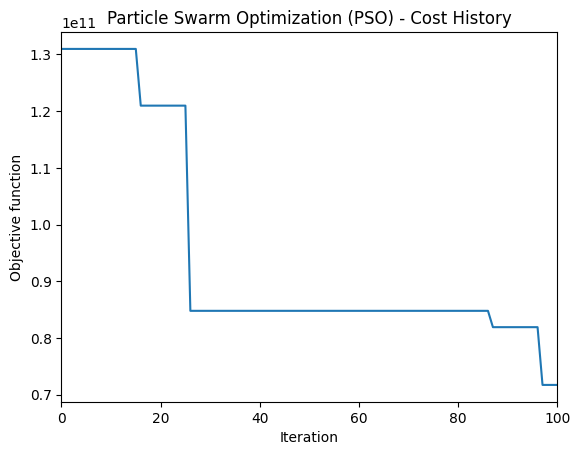

                              
*************************************************************************
Número total de iterações: 100
Número de Particulas: 100
Número de Dimensões: 24
                              
Melhor partícula: 204249566309.24286


In [125]:
# Plotar gráfico de densidade da otimização
plt.figure()
plt.plot(optimizer.cost_history)
plt.xlabel('Iteration')
plt.xlim(0, max_iterations)
plt.ylabel('Objective function')
plt.title('Particle Swarm Optimization (PSO) - Cost History')
plt.show()

print("                              ")
print("*************************************************************************")
print("Número total de iterações:", max_iterations)
print("Número de Particulas:", num_particles)
print("Número de Dimensões:", dimensions)
print("                              ")
print("Melhor partícula:", pbest_cost[0])

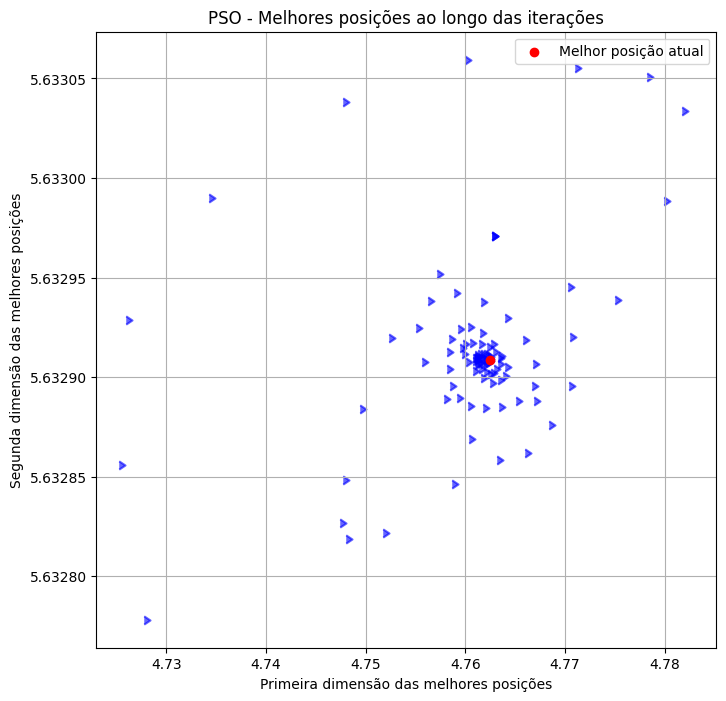

In [126]:
# Plotar o gráfico 3D com todas as melhores posições
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)

# Plotar todas as melhores posições anteriores
for i in range(best_positions.shape[0]):
    ax.scatter(best_positions[i, 0], best_positions[i, 1], marker=m, c='blue', alpha=0.6)

# Plotar a última melhor posição com uma cor diferente para destacá-la
ax.scatter(best_positions[-1, 0], best_positions[-1, 1], c='red', label='Melhor posição atual')

ax.set_title('PSO - Melhores posições ao longo das iterações')
ax.set_xlabel('Primeira dimensão das melhores posições')
ax.set_ylabel('Segunda dimensão das melhores posições')
ax.legend()
plt.grid()
plt.show()